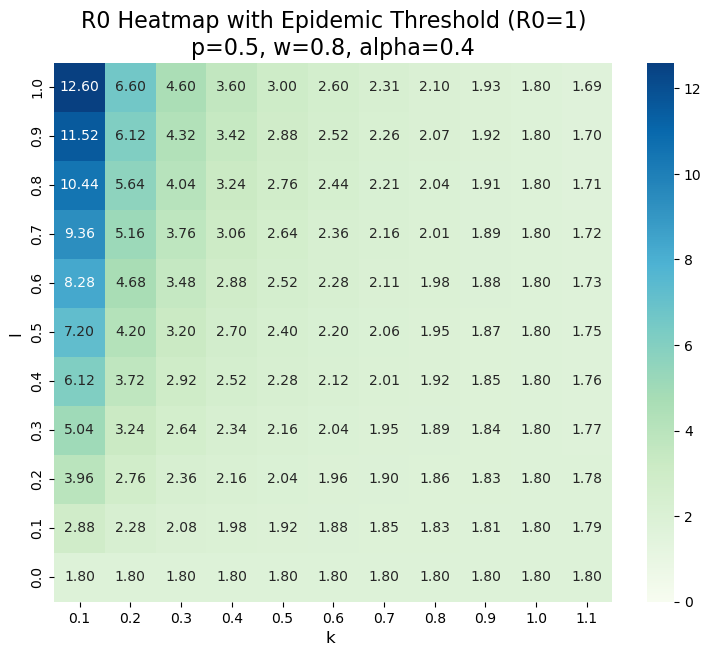

In [6]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

def get_R0_new(beta, p, w, l, k, alpha, gamma_inverse):
    """
    根据您图片中提供的新公式计算基本传染数 R0。

    Args:
        beta (float): 传播率 (the transmissibility)
        p (float): 接种疫苗的比例 (the proportion of vaccinated individuals)
        w (float): 未接种者相关的修正因子
        l (float): 疫苗相关的有效性因子
        k (float): 隔离或症状相关的修正因子
        alpha (float): 接种者相关的有效性修正因子
        gamma_inverse (float): 平均传染期 (the mean infectious period)

    Returns:
        float: 基本传染数 R0
    """
    if k == 0:
        return float('inf') # 避免除以零
        
    gamma = 1.0 / gamma_inverse
    
    # 根据新公式计算R0
    # R0 = (β / (kγ)) * { p[lα(1-k) + k] + (1-p)w[l(1-k) + k] }
    term_vaccinated = p * (l * alpha * (1 - k) + k)
    term_unvaccinated = (1 - p) * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_vaccinated + term_unvaccinated)
    
    return R0

# --- 参数设置 ---
# 和之前的脚本保持一致
p = 0.5          # 接种比例
w = 0.5          # 未接种者相关的修正因子
beta = 0.5       # 基础传播率
gamma_inverse = 4.0 # 平均传染期

# 新公式引入的参数，此处设定一个示例值
alpha = 0.4

# --- 绘图准备 ---
# x轴和y轴的标签
x_label_k = [round((i + 1) / 10.0, 1) for i in range(11)]
y_label_l = [i / 10.0 for i in range(10, -1, -1)]

# 创建一个11x11的零矩阵，用于存储R0的计算结果
m_R0 = np.zeros((11, 11))

# --- 计算R0 ---
# 遍历 l 和 k 的不同取值
# l 的取值范围: 0.0, 0.1, ..., 1.0
# k 的取值范围: 0.1, 0.2, ..., 1.1
for i, l_val in enumerate(np.linspace(0, 1, 11)):
    for j, k_val in enumerate(np.linspace(0.1, 1.1, 11)):
        # 我们将 l 从 1.0 到 0.0 的结果填入矩阵的 0 到 10 行
        l_for_calc = 1.0 - l_val
        m_R0[i, j] = get_R0_new(beta, p, w, l_for_calc, k_val, alpha, gamma_inverse)


# --- 绘制热力图和分界线 ---
plt.figure(figsize=(9, 7))

# 1. 绘制热力图
# annot=True 会在每个格子里显示R0数值，方便对比
sbn.heatmap(m_R0, vmin=0, cmap='GnBu', xticklabels=x_label_k, yticklabels=y_label_l, annot=True, fmt=".2f")

# 2. 绘制 R0 = 1 的等高线作为分界线
# 创建与热力图单元格对应的坐标网格
# 加0.5是为了让等高线平滑地穿过单元格的中心
x_coords = np.arange(m_R0.shape[1]) + 0.5
y_coords = np.arange(m_R0.shape[0]) + 0.5
X_contour, Y_contour = np.meshgrid(x_coords, y_coords)

# 使用 plt.contour 绘制等高线
# levels=[1.0] 指定了我们只关心 R0=1 这条线
contour_line = plt.contour(X_contour, Y_contour, m_R0, levels=[1.0], colors='red', linewidths=2.5)
plt.clabel(contour_line, inline=True, fontsize=12, fmt='R0 = %.1f')


# --- 设置标题和坐标轴标签 ---
plt.title(f'R0 Heatmap with Epidemic Threshold (R0=1)\np={p}, w={w}, alpha={alpha}', fontsize=16)
plt.xlabel('k ', fontsize=12)
plt.ylabel('l ', fontsize=12)
plt.show()

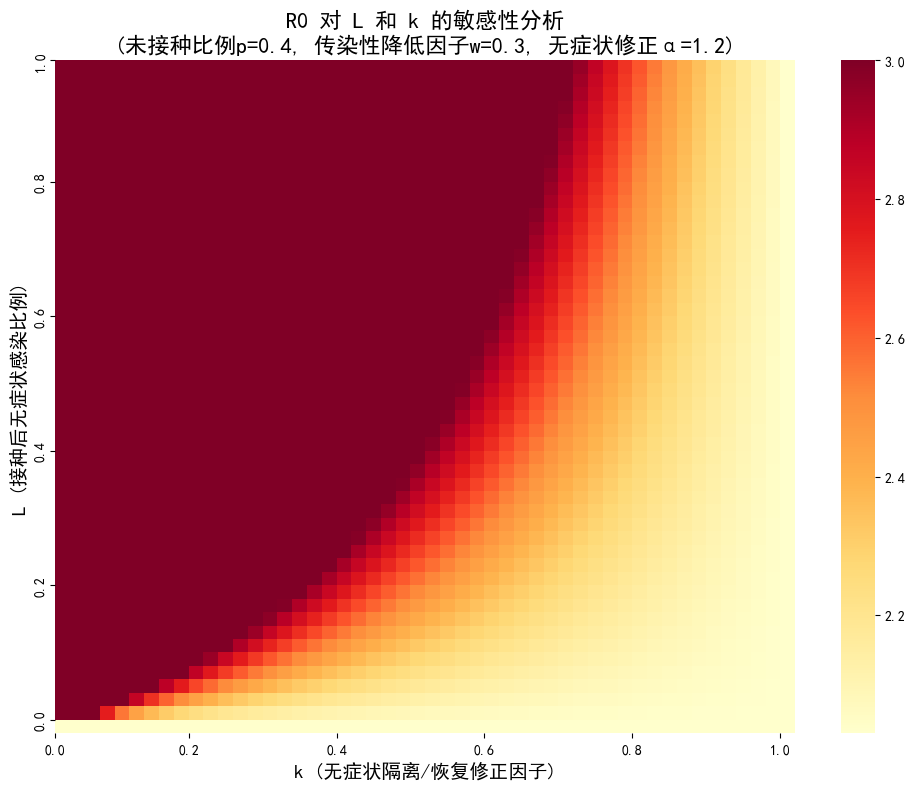

In [8]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_R0(beta, p, w, L, k, alpha, gamma):
    """
    根据您的MATLAB模型计算R0。参数的物理意义已根据您的代码进行修正。

    Args:
        beta (float): 传染率。
        p (float): 未接种疫苗的个体比例。
        w (float): 接种疫苗后降低传染率的因子。
        L (float): 接种疫苗的感染者中，转为无症状的比例。
        k (float): 无症状感染者被隔离的延迟因子 (或恢复率修正因子)。
        alpha (float): 未接种者与接种者无症状比例的修正系数 (Asymp_Unvacc = alpha * L)。
        gamma (float): 有症状感染者的恢复/隔离率。

    Returns:
        float: 基本传染数 R0
    """
    if k == 0:
        k = 1e-9 # 避免除零错误
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (L * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (L * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    
    return R0

# --- 1. 参数设定 (基于MATLAB模型的真实含义) ---
beta = 0.5           # 传染率
gamma_inverse = 7.0  # 有症状感染者的平均感染期为7天
gamma = 1.0 / gamma_inverse

# 基准情景 (Baseline Scenario)
p = 0.4              # 40% 的人未接种疫苗
w = 0.3              # 接种疫苗可使感染者的传染性降低70%
alpha = 1.2          # 假设未接种者转为无症状的比例是接种者的1.2倍

# --- 2. 计算与绘图 ---
# L: 接种疫苗后转为无症状的比例 (0% to 100%)
# k: 无症状相关的隔离/恢复修正因子 (0 to 1)
L_vals = np.linspace(0, 1, 50)  
k_vals = np.linspace(0, 1, 50)  

R0_matrix = np.zeros((len(L_vals), len(k_vals)))

for i, l_loop_var in enumerate(L_vals): # 使用 l_loop_var 以避免与参数 L 混淆
    for j, k_loop_var in enumerate(k_vals):
        R0_matrix[i, j] = calculate_R0(beta, p, w, l_loop_var, k_loop_var, alpha, gamma)

# 翻转矩阵以匹配y轴从上到下的习惯（L从1到0）
R0_matrix_flipped = np.flipud(R0_matrix)

# --- 3. 绘制热力图 ---
plt.figure(figsize=(10, 8))

heatmap = sbn.heatmap(R0_matrix_flipped, cmap='YlOrRd', vmax=3)

# 设置坐标轴 (使用修正后的参数定义)
heatmap.set_xlabel('k (delay factor)', fontsize=14)
heatmap.set_ylabel('L', fontsize=14)
heatmap.set_title(f'R0 对 L 和 k 的敏感性分析\n(未接种比例p={p}, 传染性降低因子w={w}, 无症状修正α={alpha})', fontsize=16)

# 设置刻度标签
x_ticks = np.linspace(0, len(k_vals) - 1, 6, dtype=int)
y_ticks = np.linspace(0, len(L_vals) - 1, 6, dtype=int)
heatmap.set_xticks(x_ticks)
heatmap.set_yticks(y_ticks)
heatmap.set_xticklabels([f'{k_vals[i]:.1f}' for i in x_ticks])
heatmap.set_yticklabels([f'{np.flip(L_vals)[i]:.1f}' for i in y_ticks])

# 绘制 R0 = 1 的分界线
# 创建坐标网格 (注意要和翻转后的矩阵对应)
X, Y = np.meshgrid(np.arange(len(k_vals)), np.arange(len(L_vals))) # <<<--- 此处已修正
contour_line = plt.contour(X, Y, R0_matrix_flipped, levels=[1.0], colors='blue', linewidths=3)
plt.clabel(contour_line, inline=True, fontsize=12, fmt='R0 = %.1f')

plt.tight_layout()
plt.show()

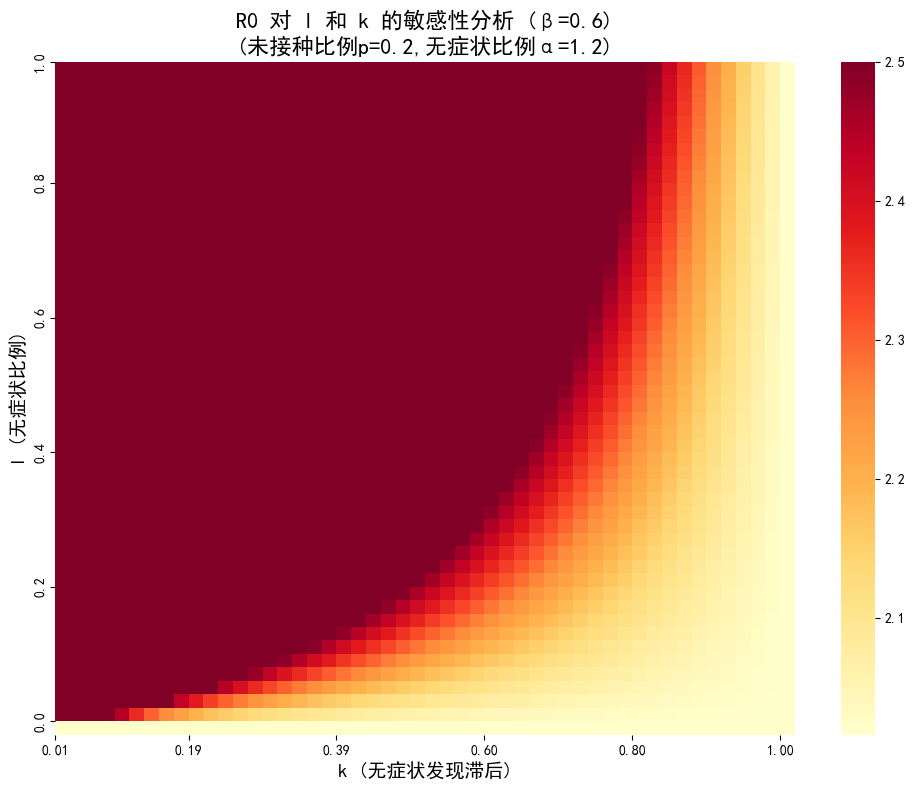

In [23]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_R0(beta, p, w, l, k, alpha, gamma):
    """
    根据您最终提供的SEIAQ模型图计算R0。

    Args:
        beta (float): 基础传染率。
        p (float): 未接种疫苗的个体比例。
        w (float): 疫苗降低易感性的保护因子 (w < 1)。
        l (float): 接种疫苗的感染者中，转为无症状(Ã)的比例。
        k (float): 无症状感染者恢复/隔离率的修正因子 (k < 1)。
        alpha (float): 未接种者与接种者无症状比例的修正系数 (Â的比例 = α * l)。
        gamma (float): 有症状感染者的恢复/隔离率。

    Returns:
        float: 基本传染数 R0
    """
    if k <= 0:
        k = 1e-9 # 避免除零或负数错误
    
    proportion_vaccinated = 1.0 - p
    
    # R0公式由下一代矩阵法推导得出，与您的MATLAB结果一致
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    
    return R0

# --- 1. 参数设定 (基于最终模型图) ---
# 为了能观察到R0=1分界线，我们设定一个较低的传染率
beta = 0.6          # 基础传染率

gamma_inverse = 4  # 有症状感染者的平均感染期为7天
gamma = 1.0 / gamma_inverse

# 设定基准情景
p = 0.2              # 人群中有40%未接种疫苗
w = 0.8              # 疫苗可使被感染的概率降低70%
alpha = 1.2          # 未接种者成为无症状的比例是接种者的1.2倍

# --- 2. 核心实验：分析 l 和 k 的影响 ---
# l: 疫苗诱导无症状的能力 (0=全有症状, 1=全无症状)
# k: 对无症状者的管控能力 (0=立刻隔离, 1=与有症状者隔离速度相同)
l_vals = np.linspace(0, 1, 50)  
k_vals = np.linspace(0.01, 1, 50) # k从一个小的正数开始，避免为0

R0_matrix = np.zeros((len(l_vals), len(k_vals)))

for i, l_val in enumerate(l_vals):
    for j, k_val in enumerate(k_vals):
        R0_matrix[i, j] = calculate_R0(beta, p, w, l_val, k_val, alpha, gamma)

# 翻转矩阵以匹配y轴从上到下的习惯（l从1到0）
R0_matrix_flipped = np.flipud(R0_matrix)

# --- 3. 绘制热力图及R0=1分界线 ---
plt.figure(figsize=(10, 8))

# vmax=2.5 将颜色刻度的最大值设为2.5，让颜色变化更丰富
heatmap = sbn.heatmap(R0_matrix_flipped, cmap='YlOrRd', vmax=2.5)

# 设置坐标轴标签，与模型图定义完全对应
heatmap.set_xlabel('k (无症状发现滞后)', fontsize=14)
heatmap.set_ylabel('l (无症状比例)', fontsize=14)
heatmap.set_title(f'R0 对 l 和 k 的敏感性分析 (β={beta})\n(未接种比例p={p},无症状比例α={alpha})', fontsize=16)

# 设置坐标轴刻度
x_ticks = np.linspace(0, len(k_vals) - 1, 6, dtype=int)
y_ticks = np.linspace(0, len(l_vals) - 1, 6, dtype=int)
heatmap.set_xticks(x_ticks)
heatmap.set_yticks(y_ticks)
heatmap.set_xticklabels([f'{k_vals[i]:.2f}' for i in x_ticks])
heatmap.set_yticklabels([f'{np.flip(l_vals)[i]:.1f}' for i in y_ticks])

# 绘制 R0 = 1 的分界线
X, Y = np.meshgrid(np.arange(len(k_vals)), np.arange(len(l_vals)))
contour_line = plt.contour(X, Y, R0_matrix_flipped, levels=[1.0], colors='blue', linewidths=3)
plt.clabel(contour_line, inline=True, fontsize=12, fmt='R0 = %.1f')

plt.tight_layout()
plt.show()

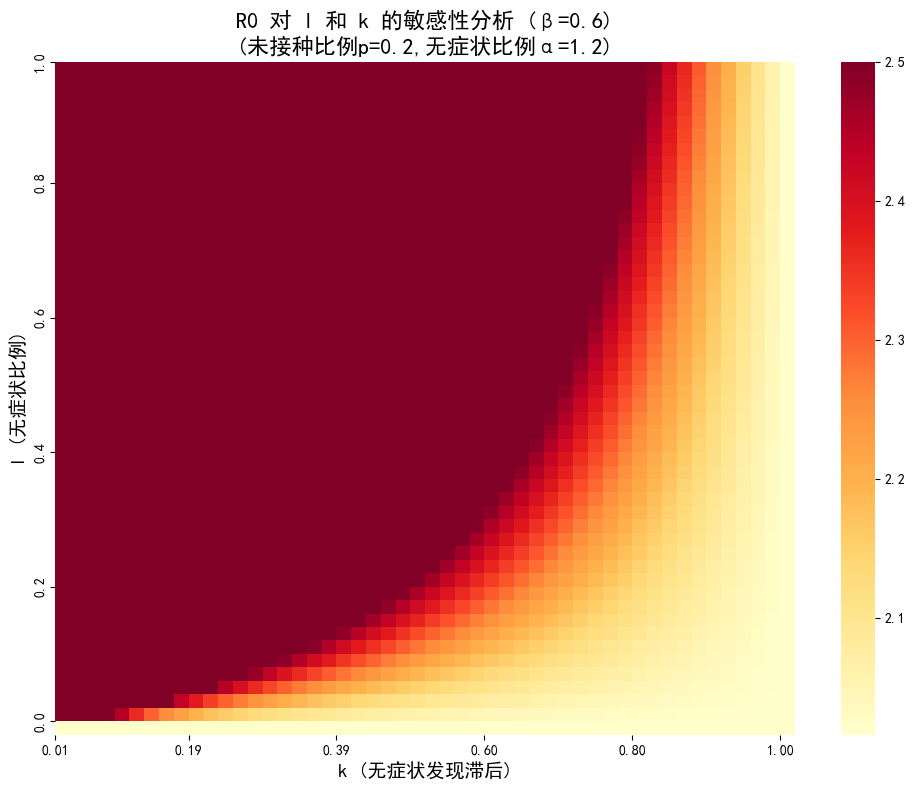

In [25]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_R0(beta, p, w, l, k, alpha, gamma):
    """
    根据您最终提供的SEIAQ模型图计算R0。

    Args:
        beta (float): 基础传染率。
        p (float): 未接种疫苗的个体比例。
        l (float): 接种疫苗的感染者中，转为无症状(Ã)的比例。
        k (float): 无症状感染者恢复/隔离率的修正因子 (k < 1)。
        alpha (float): 未接种者与接种者无症状比例的修正系数 (Â的比例 = α * l)。
        gamma (float): 有症状感染者的恢复/隔离率。

    Returns:
        float: 基本传染数 R0
    """
    if k <= 0:
        k = 1e-9 # 避免除零或负数错误
    
    proportion_vaccinated = 1.0 - p
    
    # R0公式由下一代矩阵法推导得出，与您的MATLAB结果一致
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    
    return R0

# --- 1. 参数设定 (基于最终模型图) ---
beta = 0.6           # 基础传染率
gamma_inverse = 4    # 有症状感染者的平均感染期为4天
gamma = 1.0 / gamma_inverse

# 设定基准情景
p = 0.2              # 人群中有20%未接种疫苗
w = 0.8              # 疫苗可使被感染的概率降低20%
alpha = 1.2          # 未接种者成为无症状的比例是接种者的1.2倍

# --- 2. 核心实验：分析 l 和 k 的影响 ---
l_vals = np.linspace(0, 1, 50)  
k_vals = np.linspace(0.01, 1, 50) # k从一个小的正数开始，避免为0

R0_matrix = np.zeros((len(l_vals), len(k_vals)))

for i, l_val in enumerate(l_vals):
    for j, k_val in enumerate(k_vals):
        R0_matrix[i, j] = calculate_R0(beta, p, w, l_val, k_val, alpha, gamma)

R0_matrix_flipped = np.flipud(R0_matrix)

# --- 3. 绘制热力图及R0=1分界线 ---
plt.figure(figsize=(10, 8))

heatmap = sbn.heatmap(R0_matrix_flipped, cmap='YlOrRd', vmax=2.5)

# 设置坐标轴标签，与模型图定义完全对应
heatmap.set_xlabel('k (无症状发现滞后)', fontsize=14)
heatmap.set_ylabel('l (无症状比例)', fontsize=14)
heatmap.set_title(f'R0 对 l 和 k 的敏感性分析 (β={beta})\n(未接种比例p={p},无症状比例α={alpha})', fontsize=16)

# 设置坐标轴刻度
x_ticks = np.linspace(0, len(k_vals) - 1, 6, dtype=int)
y_ticks = np.linspace(0, len(l_vals) - 1, 6, dtype=int)
heatmap.set_xticks(x_ticks)
heatmap.set_yticks(y_ticks)
heatmap.set_xticklabels([f'{k_vals[i]:.2f}' for i in x_ticks])
heatmap.set_yticklabels([f'{np.flip(l_vals)[i]:.1f}' for i in y_ticks])

# 绘制 R0 = 1 的分界线
X, Y = np.meshgrid(np.arange(len(k_vals)), np.arange(len(l_vals)))
contour_line = plt.contour(X, Y, R0_matrix_flipped, levels=[1.0], colors='blue', linewidths=3)
plt.clabel(contour_line, inline=True, fontsize=12, fmt='R0 = %.1f')

plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

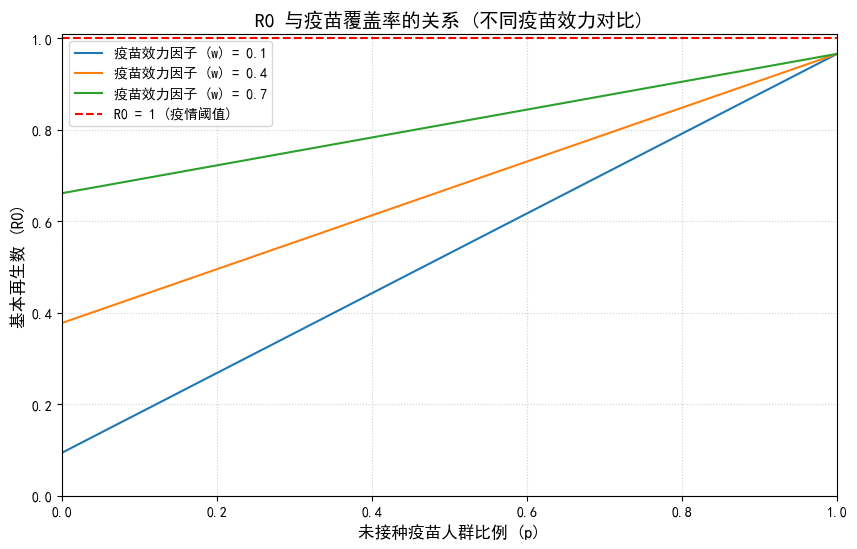

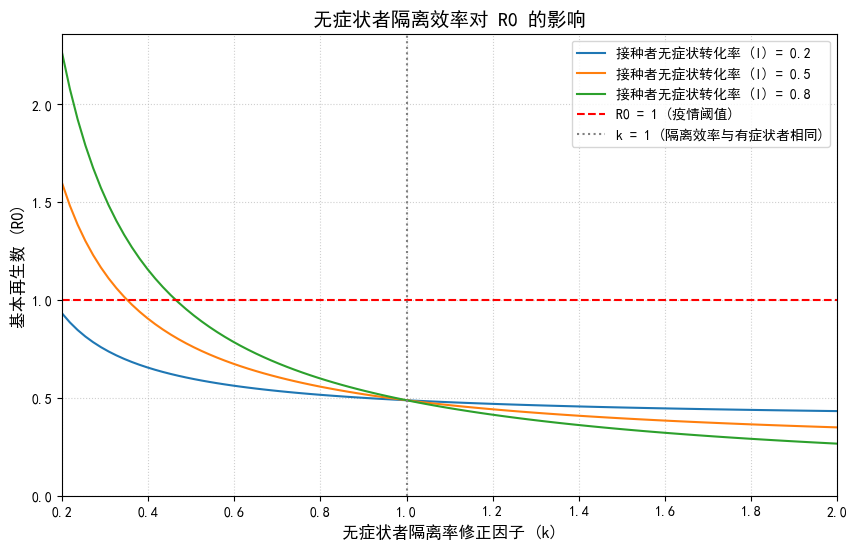

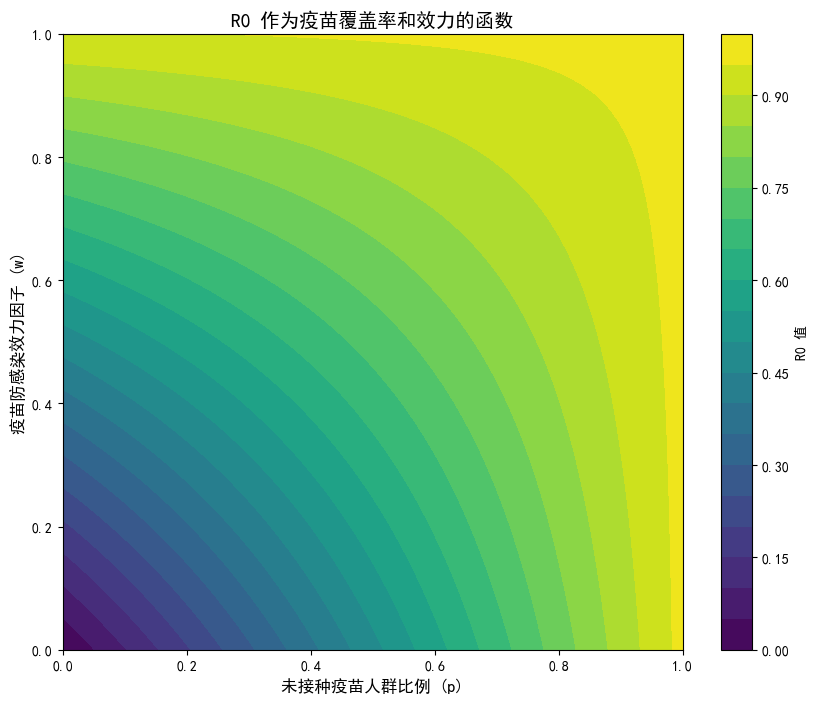

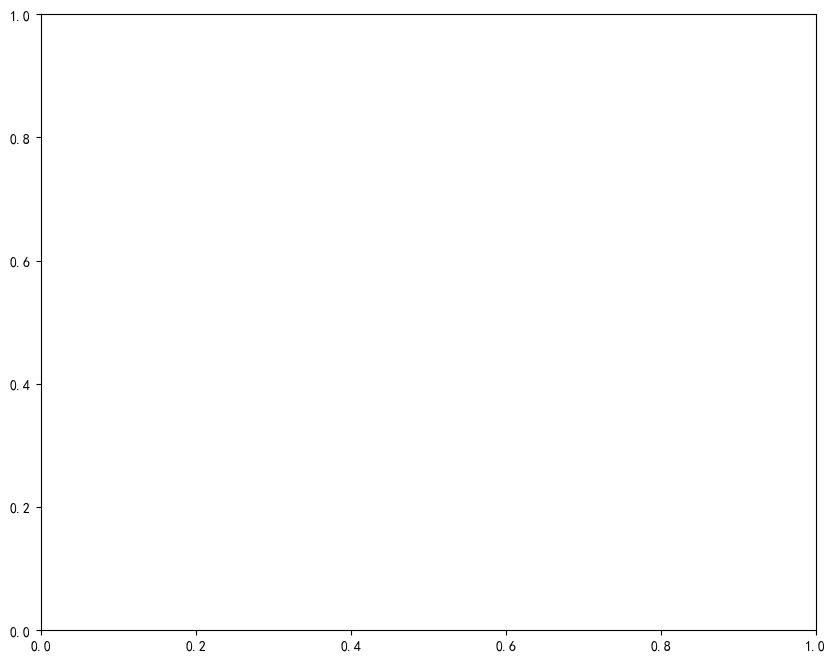

In [2]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    """
    if k <= 0:
        k = 1e-9 # 避免除零或负数错误
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.12,          # 基础传染率
    'gamma': 1.0 / 7.0,    # 有症状感染者的恢复/隔离率
    'p': 0.4,              # 40% 的人未接种疫苗
    'w': 0.3,              # 疫苗可使被感染的概率降低70%
    'l': 0.5,              # 接种后50%转为无症状
    'k': 0.8,              # 无症状者隔离率修正因子
    'alpha': 1.2,          # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制四张图表 ---

# --- 图1: R0 vs. 疫苗覆盖率 (p) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))

p_values = np.linspace(0, 1, 101)
w_scenarios = [0.1, 0.4, 0.7] # 三种不同的疫苗效力情景

for w_val in w_scenarios:
    r0_values = [calculate_r0(beta=baseline_params['beta'], k=baseline_params['k'], gamma=baseline_params['gamma'], 
                              p=p_val, l=baseline_params['l'], alpha=baseline_params['alpha'], w=w_val) for p_val in p_values]
    ax1.plot(p_values, r0_values, label=f'疫苗效力因子 (w) = {w_val}')

ax1.axhline(y=1.0, color='r', linestyle='--', label='R0 = 1 (疫情阈值)')
ax1.set_xlabel('未接种疫苗人群比例 (p)', fontsize=12)
ax1.set_ylabel('基本再生数 (R0)', fontsize=12)
ax1.set_title('R0 与疫苗覆盖率的关系 (不同疫苗效力对比)', fontsize=14)
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.set_xlim(0, 1)
ax1.set_ylim(bottom=0)


# --- 图2: R0 vs. 无症状者隔离延迟 (k) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))

k_values = np.linspace(0.2, 2.0, 101)
l_scenarios = [0.2, 0.5, 0.8] # 不同的无症状感染比例

for l_val in l_scenarios:
    r0_values = [calculate_r0(beta=baseline_params['beta'], k=k_val, gamma=baseline_params['gamma'], 
                              p=baseline_params['p'], l=l_val, alpha=baseline_params['alpha'], w=baseline_params['w']) for k_val in k_values]
    ax2.plot(k_values, r0_values, label=f'接种者无症状转化率 (l) = {l_val}')

ax2.axhline(y=1.0, color='r', linestyle='--', label='R0 = 1 (疫情阈值)')
ax2.axvline(x=1.0, color='grey', linestyle=':', label='k = 1 (隔离效率与有症状者相同)')
ax2.set_xlabel('无症状者隔离率修正因子 (k)', fontsize=12)
ax2.set_ylabel('基本再生数 (R0)', fontsize=12)
ax2.set_title('无症状者隔离效率对 R0 的影响', fontsize=14)
ax2.legend()
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.set_xlim(0.2, 2.0)
ax2.set_ylim(bottom=0)


# --- 图3: R0 二维热图 (p vs w) ---
fig3, ax3 = plt.subplots(figsize=(10, 8))

p_grid = np.linspace(0, 1, 50)
w_grid = np.linspace(0, 1, 50)
P, W = np.meshgrid(p_grid, w_grid)

R0_grid = calculate_r0(beta=baseline_params['beta'], k=baseline_params['k'], gamma=baseline_params['gamma'], 
                       p=P, l=baseline_params['l'], alpha=baseline_params['alpha'], w=W)

contour = ax3.contourf(P, W, R0_grid, levels=20, cmap='viridis')
fig3.colorbar(contour, ax=ax3, label='R0 值')
# 标记 R0 = 1 的临界线
contour_line = ax3.contour(P, W, R0_grid, levels=[1.0], colors='red', linewidths=3)
ax3.clabel(contour_line, inline=True, fontsize=10, fmt='R0=%.1f')

ax3.set_xlabel('未接种疫苗人群比例 (p)', fontsize=12)
ax3.set_ylabel('疫苗防感染效力因子 (w)', fontsize=12)
ax3.set_title('R0 作为疫苗覆盖率和效力的函数', fontsize=14)


# --- 图4: R0 二维热图 (k vs l) ---
fig4, ax4 = plt.subplots(figsize=(10, 8))

k_grid = np.linspace(0.2, 1.5, 50)
l_grid = np.linspace(0, 1, 50)
K, L = np.meshgrid(k_grid, l_grid)

R0_grid_kl = calculate_r0(beta=baseline_params['beta'], k=K, gamma=baseline_params['gamma'], 
                          p=baseline_params['p'], l=L, alpha=baseline_params['alpha'], w=baseline_params['w'])

contour_kl = ax4.contourf(K, L, R0_grid_kl, levels=20, cmap='plasma')
fig4.colorbar(contour_kl, ax=ax4, label='R0 值')
# 标记 R0 = 1 的临界线
contour_line_kl = ax4.contour(K, L, R0_grid_kl, levels=[1.0], colors='white', linewidths=3)
ax4.clabel(contour_line_kl, inline=True, fontsize=10, fmt='R0=%.1f')

ax4.set_xlabel('无症状者隔离率修正因子 (k)', fontsize=12)
ax4.set_ylabel('接种者无症状转化率 (l)', fontsize=12)
ax4.set_title('R0 作为无症状传播动态的函数', fontsize=14)


plt.tight_layout()
plt.show()

正在保存图像为PDF文件...
所有图像已成功保存。


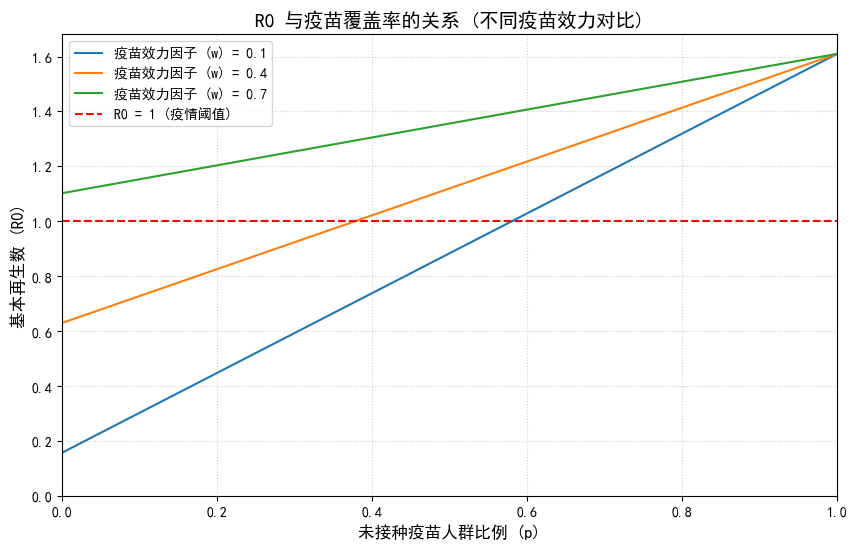

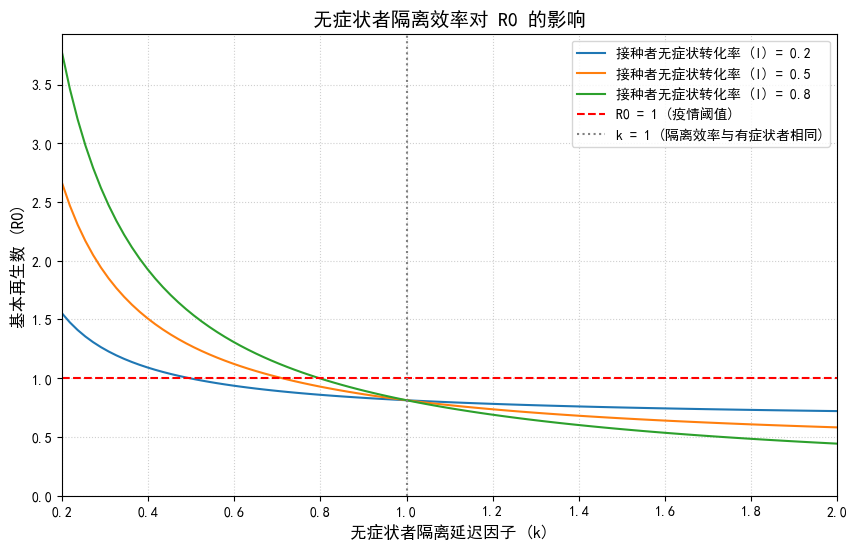

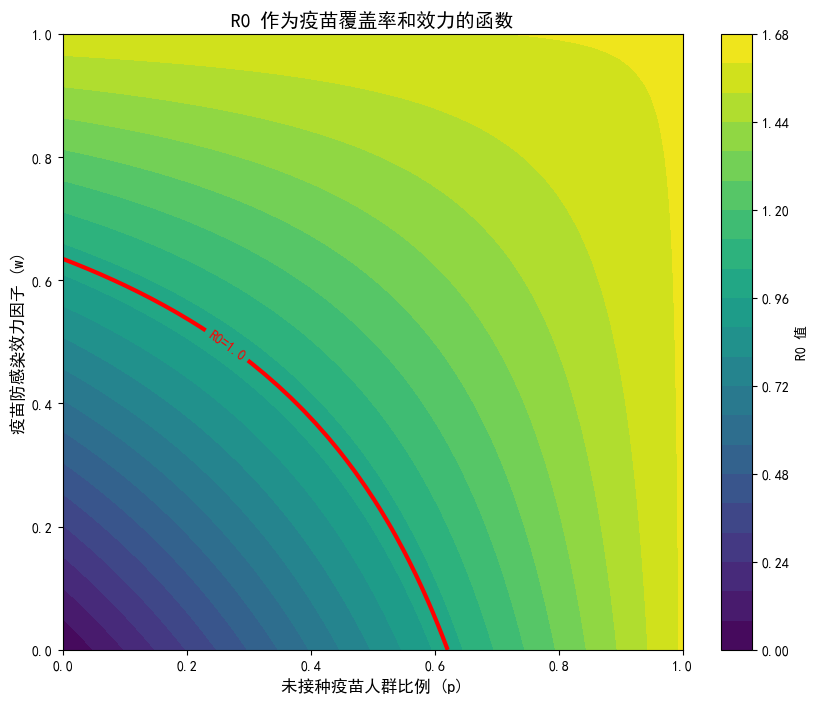

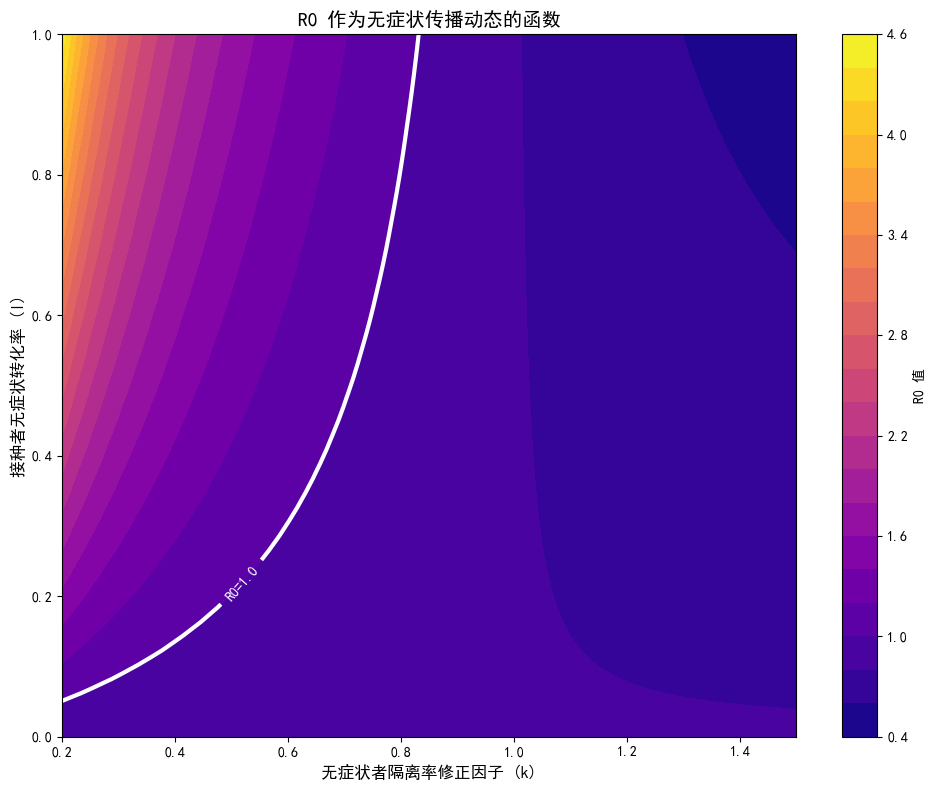

In [2]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    """
    # --- ↓↓↓ 这里是唯一的修改 ↓↓↓ ---
    # 使用 np.where 替换 if 语句，使其能处理数组
    k = np.where(k <= 0, 1e-9, k)
    # --- ↑↑↑ 这里是唯一的修改 ↑↑↑ ---
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.2,          # 基础传染率
    'gamma': 1.0 / 7.0,    # 有症状感染者的恢复/隔离率
    'p': 0.4,              # 40% 的人未接种疫苗
    'w': 0.3,              # 疫苗可使被感染的概率降低70%
    'l': 0.5,              # 接种后50%转为无症状
    'k': 0.8,              # 无症状者隔离率修正因子
    'alpha': 1.2,          # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制四张图表 ---

# --- 图1: R0 vs. 疫苗覆盖率 (p) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))

p_values = np.linspace(0, 1, 101)
w_scenarios = [0.1, 0.4, 0.7] # 三种不同的疫苗效力情景

for w_val in w_scenarios:
    r0_values = [calculate_r0(beta=baseline_params['beta'], k=baseline_params['k'], gamma=baseline_params['gamma'], 
                              p=p_val, l=baseline_params['l'], alpha=baseline_params['alpha'], w=w_val) for p_val in p_values]
    ax1.plot(p_values, r0_values, label=f'疫苗效力因子 (w) = {w_val}')

ax1.axhline(y=1.0, color='r', linestyle='--', label='R0 = 1 (疫情阈值)')
ax1.set_xlabel('未接种疫苗人群比例 (p)', fontsize=12)
ax1.set_ylabel('基本再生数 (R0)', fontsize=12)
ax1.set_title('R0 与疫苗覆盖率的关系 (不同疫苗效力对比)', fontsize=14)
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.set_xlim(0, 1)
ax1.set_ylim(bottom=0)


# --- 图2: R0 vs. 无症状者隔离延迟 (k) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))

k_values = np.linspace(0.2, 2.0, 101)
l_scenarios = [0.2, 0.5, 0.8] # 不同的无症状感染比例

for l_val in l_scenarios:
    r0_values = [calculate_r0(beta=baseline_params['beta'], k=k_val, gamma=baseline_params['gamma'], 
                              p=baseline_params['p'], l=l_val, alpha=baseline_params['alpha'], w=baseline_params['w']) for k_val in k_values]
    ax2.plot(k_values, r0_values, label=f'接种者无症状转化率 (l) = {l_val}')

ax2.axhline(y=1.0, color='r', linestyle='--', label='R0 = 1 (疫情阈值)')
ax2.axvline(x=1.0, color='grey', linestyle=':', label='k = 1 (隔离效率与有症状者相同)')
ax2.set_xlabel('无症状者隔离延迟因子 (k)', fontsize=12)
ax2.set_ylabel('基本再生数 (R0)', fontsize=12)
ax2.set_title('无症状者隔离效率对 R0 的影响', fontsize=14)
ax2.legend()
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.set_xlim(0.2, 2.0)
ax2.set_ylim(bottom=0)


# --- 图3: R0 二维热图 (p vs w) ---
fig3, ax3 = plt.subplots(figsize=(10, 8))

p_grid = np.linspace(0, 1, 50)
w_grid = np.linspace(0, 1, 50)
P, W = np.meshgrid(p_grid, w_grid)

R0_grid = calculate_r0(beta=baseline_params['beta'], k=baseline_params['k'], gamma=baseline_params['gamma'], 
                       p=P, l=baseline_params['l'], alpha=baseline_params['alpha'], w=W)

contour = ax3.contourf(P, W, R0_grid, levels=20, cmap='viridis')
fig3.colorbar(contour, ax=ax3, label='R0 值')
# 标记 R0 = 1 的临界线
contour_line = ax3.contour(P, W, R0_grid, levels=[1.0], colors='red', linewidths=3)
ax3.clabel(contour_line, inline=True, fontsize=10, fmt='R0=%.1f')

ax3.set_xlabel('未接种疫苗人群比例 (p)', fontsize=12)
ax3.set_ylabel('疫苗防感染效力因子 (w)', fontsize=12)
ax3.set_title('R0 作为疫苗覆盖率和效力的函数', fontsize=14)


# --- 图4: R0 二维热图 (k vs l) ---
fig4, ax4 = plt.subplots(figsize=(10, 8))

k_grid = np.linspace(0.2, 1.5, 50)
l_grid = np.linspace(0, 1, 50)
K, L = np.meshgrid(k_grid, l_grid)

R0_grid_kl = calculate_r0(beta=baseline_params['beta'], k=K, gamma=baseline_params['gamma'], 
                          p=baseline_params['p'], l=L, alpha=baseline_params['alpha'], w=baseline_params['w'])

contour_kl = ax4.contourf(K, L, R0_grid_kl, levels=20, cmap='plasma')
fig4.colorbar(contour_kl, ax=ax4, label='R0 值')
# 标记 R0 = 1 的临界线
contour_line_kl = ax4.contour(K, L, R0_grid_kl, levels=[1.0], colors='white', linewidths=3)
ax4.clabel(contour_line_kl, inline=True, fontsize=10, fmt='R0=%.1f')

ax4.set_xlabel('无症状者隔离率修正因子 (k)', fontsize=12)
ax4.set_ylabel('接种者无症状转化率 (l)', fontsize=12)
ax4.set_title('R0 作为无症状传播动态的函数', fontsize=14)

print("正在保存图像为PDF文件...")

# 保存图1
fig1.savefig("R0_vs_Vaccination_Coverage.pdf", bbox_inches='tight')
# 保存图2
fig2.savefig("R0_vs_Asymptomatic_Isolation.pdf", bbox_inches='tight')
# 保存图3
fig3.savefig("R0_Heatmap_p_vs_w.pdf", bbox_inches='tight')
# 保存图4
fig4.savefig("R0_Heatmap_k_vs_l.pdf", bbox_inches='tight')

print("所有图像已成功保存。")

plt.tight_layout()
plt.show()

In [19]:
###源代码

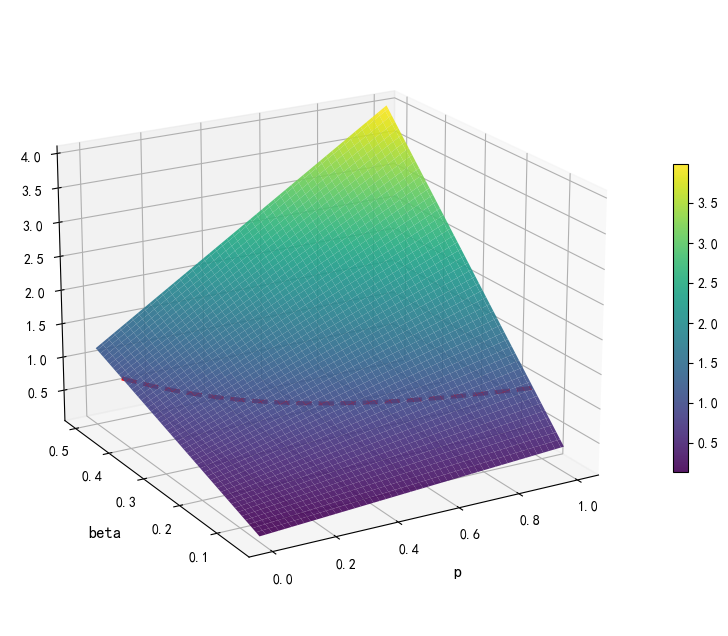

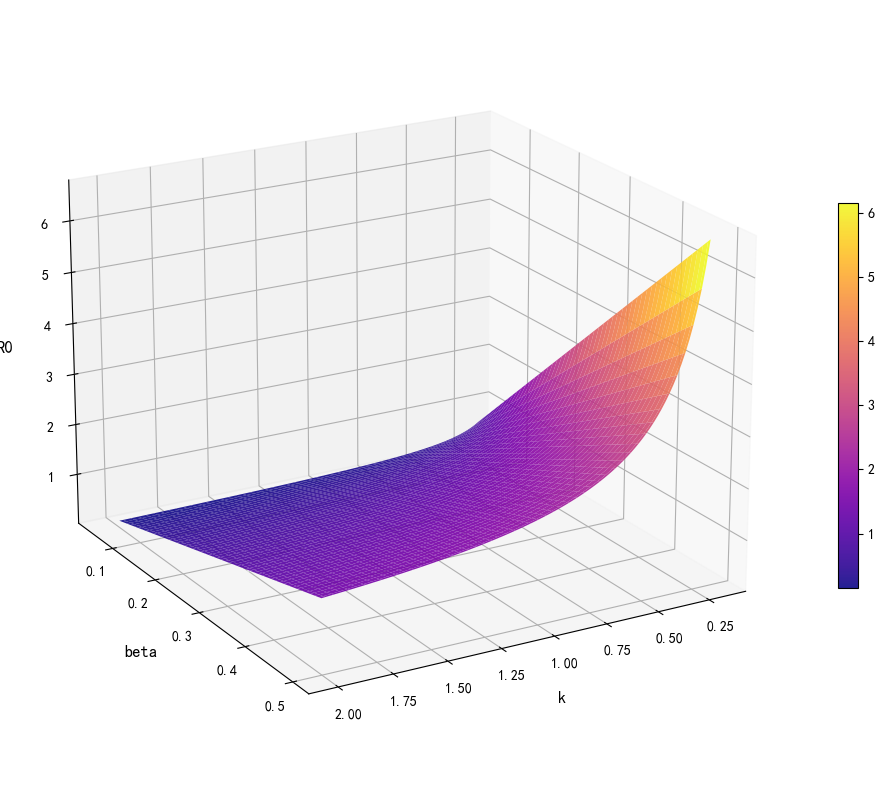

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
# 请确保您的环境中已安装 SimHei 字体，或者替换为您系统中的其他中文字体
try:
    mpl.rcParams['font.sans-serif'] = ['SimHei']
    mpl.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"未能设置中文字体，将使用默认字体。错误信息: {e}")


def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    此函数已向量化，可以直接处理Numpy数组。
    """
    # 使用 np.where 替换 if 语句，以处理数组输入并避免除以零
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.2,         # 基础传染率 (在3D图中将作为变量)
    'gamma': 1.0 / 7.0,  # 有症状感染者的恢复/隔离率
    'p': 0.4,            # 40% 的人未接种疫苗 (在3D图1中作为变量)
    'w': 0.3,            # 疫苗可使被感染的概率降低70% (w越小效力越强)
    'l': 0.5,            # 接种后感染转为无症状的比例
    'k': 0.8,            # 无症状者隔离率修正因子 (在3D图2中作为变量)
    'alpha': 1.2,        # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制两张三维图表 ---

# --- 图1 (改进版): R0 vs. 疫苗覆盖率(p) 和 传染率(beta) ---
fig1_3d = plt.figure(figsize=(12, 8))
ax1_3d = fig1_3d.add_subplot(111, projection='3d')

# 定义 p 和 beta 的范围
p_values = np.linspace(0, 1, 100)
beta_values = np.linspace(0.05, 0.5, 100)
P, BETA = np.meshgrid(p_values, beta_values)

# 计算 R0 曲面 (固定其他参数为基准值)
R0_surface1 = calculate_r0(
    beta=BETA,
    p=P,
    w=baseline_params['w'],
    l=baseline_params['l'],
    k=baseline_params['k'],
    alpha=baseline_params['alpha'],
    gamma=baseline_params['gamma']
)

# 绘制3D曲面
surf1 = ax1_3d.plot_surface(P, BETA, R0_surface1, cmap='viridis', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线，作为疫情爆发的临界线
ax1_3d.contour(P, BETA, R0_surface1, levels=[1.0], colors='red', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax1_3d.set_xlabel('p', fontsize=12, labelpad=10)
ax1_3d.set_ylabel('beta', fontsize=12, labelpad=10)
ax1_3d.set_zlabel('R0', fontsize=12, labelpad=10)
# ax1_3d.set_title('R0 作为疫苗覆盖率和传染率的函数', fontsize=16)
fig1_3d.colorbar(surf1, shrink=0.5, aspect=20)

# 调整初始视角，便于观察
ax1_3d.view_init(elev=20, azim=-120) 


# --- 图2 (改进版): R0 vs. 无症状者隔离效率(k) 和 传染率(beta) ---
fig2_3d = plt.figure(figsize=(12, 8))
ax2_3d = fig2_3d.add_subplot(111, projection='3d')

# 定义 k 和 beta 的范围
k_values = np.linspace(0.2, 2.0, 100)
# beta_values 保持不变
K, BETA_k = np.meshgrid(k_values, beta_values)

# 计算 R0 曲面 (固定其他参数为基准值)
R0_surface2 = calculate_r0(
    beta=BETA_k,
    p=baseline_params['p'],
    w=baseline_params['w'],
    l=baseline_params['l'],
    k=K,
    alpha=baseline_params['alpha'],
    gamma=baseline_params['gamma']
)

# 绘制3D曲面
surf2 = ax2_3d.plot_surface(K, BETA_k, R0_surface2, cmap='plasma', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线
ax2_3d.contour(K, BETA_k, R0_surface2, levels=[1.0], colors='white', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax2_3d.set_xlabel('k', fontsize=12, labelpad=10)
ax2_3d.set_ylabel('beta', fontsize=12, labelpad=10)
ax2_3d.set_zlabel('R0', fontsize=12, labelpad=10)
# ax2_3d.set_title('R0 作为无症状者隔离效率和传染率的函数', fontsize=16)
fig2_3d.colorbar(surf2, shrink=0.5, aspect=20)

# 调整初始视角
ax2_3d.view_init(elev=20, azim=60)


# 显示所有图像
plt.tight_layout()
plt.show()

In [21]:
#增加字体

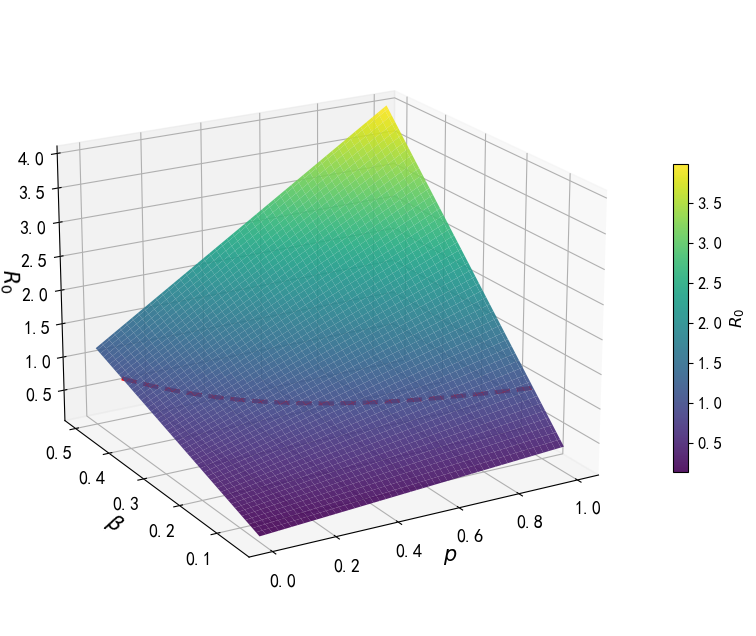

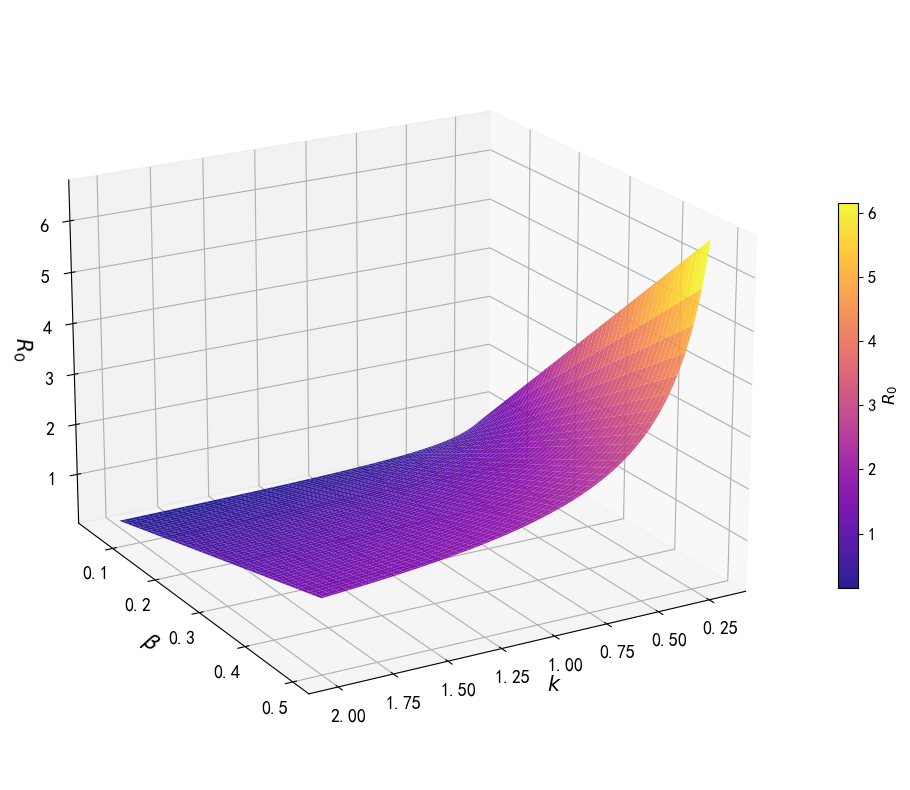

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
# 请确保您的环境中已安装 SimHei 字体，或者替换为您系统中的其他中文字体
try:
    mpl.rcParams['font.sans-serif'] = ['SimHei']
    mpl.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"未能设置中文字体，将使用默认字体。错误信息: {e}")


def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    此函数已向量化，可以直接处理Numpy数组。
    """
    # 使用 np.where 替换 if 语句，以处理数组输入并避免除以零
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.2,         # 基础传染率 (在3D图中将作为变量)
    'gamma': 1.0 / 7.0,  # 有症状感染者的恢复/隔离率
    'p': 0.4,            # 40% 的人未接种疫苗 (在3D图1中作为变量)
    'w': 0.3,            # 疫苗可使被感染的概率降低70% (w越小效力越强)
    'l': 0.5,            # 接种后感染转为无症状的比例
    'k': 0.8,            # 无症状者隔离率修正因子 (在3D图2中作为变量)
    'alpha': 1.2,        # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制两张三维图表 ---

# --- 图1 (改进版): R0 vs. 疫苗覆盖率(p) 和 传染率(beta) ---
fig1_3d = plt.figure(figsize=(12, 8))
ax1_3d = fig1_3d.add_subplot(111, projection='3d')

# 定义 p 和 beta 的范围
p_values = np.linspace(0, 1, 100)
beta_values = np.linspace(0.05, 0.5, 100)
P, BETA = np.meshgrid(p_values, beta_values)

# 计算 R0 曲面 (固定其他参数为基准值)
R0_surface1 = calculate_r0(
    beta=BETA,
    p=P,
    w=baseline_params['w'],
    l=baseline_params['l'],
    k=baseline_params['k'],
    alpha=baseline_params['alpha'],
    gamma=baseline_params['gamma']
)

# 绘制3D曲面
surf1 = ax1_3d.plot_surface(P, BETA, R0_surface1, cmap='viridis', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线，作为疫情爆发的临界线
ax1_3d.contour(P, BETA, R0_surface1, levels=[1.0], colors='red', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax1_3d.set_xlabel(r'$p$', fontsize=15, labelpad=2)
# --- ↓↓↓ 修改1：使用LaTeX显示希腊字母beta ↓↓↓ ---
ax1_3d.set_ylabel(r'$\beta$', fontsize=15, labelpad=4)
ax1_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=2)
# ax1_3d.set_title('R0 作为疫苗覆盖率和传染率的函数', fontsize=16)

# --- ↓↓↓ 修改2：获取colorbar对象并设置其刻度字体大小 ↓↓↓ ---
cb1 = fig1_3d.colorbar(surf1, shrink=0.5, aspect=20)
cb1.ax.tick_params(labelsize=12)
cb1.set_label(r'$R_0$', size=12) # 也可以顺便调整colorbar本身的标签大小

# 调整初始视角，便于观察
ax1_3d.view_init(elev=20, azim=-120) 


# --- 图2 (改进版): R0 vs. 无症状者隔离效率(k) 和 传染率(beta) ---
fig2_3d = plt.figure(figsize=(12, 8))
ax2_3d = fig2_3d.add_subplot(111, projection='3d')

# 定义 k 和 beta 的范围
k_values = np.linspace(0.2, 2.0, 100)
# beta_values 保持不变
K, BETA_k = np.meshgrid(k_values, beta_values)

# 计算 R0 曲面 (固定其他参数为基准值)
R0_surface2 = calculate_r0(
    beta=BETA_k,
    p=baseline_params['p'],
    w=baseline_params['w'],
    l=baseline_params['l'],
    k=K,
    alpha=baseline_params['alpha'],
    gamma=baseline_params['gamma']
)

# 绘制3D曲面
surf2 = ax2_3d.plot_surface(K, BETA_k, R0_surface2, cmap='plasma', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线
ax2_3d.contour(K, BETA_k, R0_surface2, levels=[1.0], colors='white', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax2_3d.set_xlabel(r'$k$', fontsize=15, labelpad=2)
# --- ↓↓↓ 修改1：使用LaTeX显示希腊字母beta ↓↓↓ ---
ax2_3d.set_ylabel(r'$\beta$', fontsize=15, labelpad=4)
ax2_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=2)
# ax2_3d.set_title('R0 作为无症状者隔离效率和传染率的函数', fontsize=16)

# --- ↓↓↓ 修改2：获取colorbar对象并设置其刻度字体大小 ↓↓↓ ---
cb2 = fig2_3d.colorbar(surf2, shrink=0.5, aspect=20)
cb2.ax.tick_params(labelsize=12)
cb2.set_label(r'$R_0$', size=12)

tick_font_size = 13

ax1_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax1_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax1_3d.zaxis.set_tick_params(labelsize=tick_font_size)


ax2_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax2_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax2_3d.zaxis.set_tick_params(labelsize=tick_font_size)
# 调整初始视角
ax2_3d.view_init(elev=20, azim=60)


# 显示所有图像
plt.tight_layout()
plt.show()

In [22]:
#输出PDF

正在将图像保存为PDF文件...
PDF文件已成功保存。


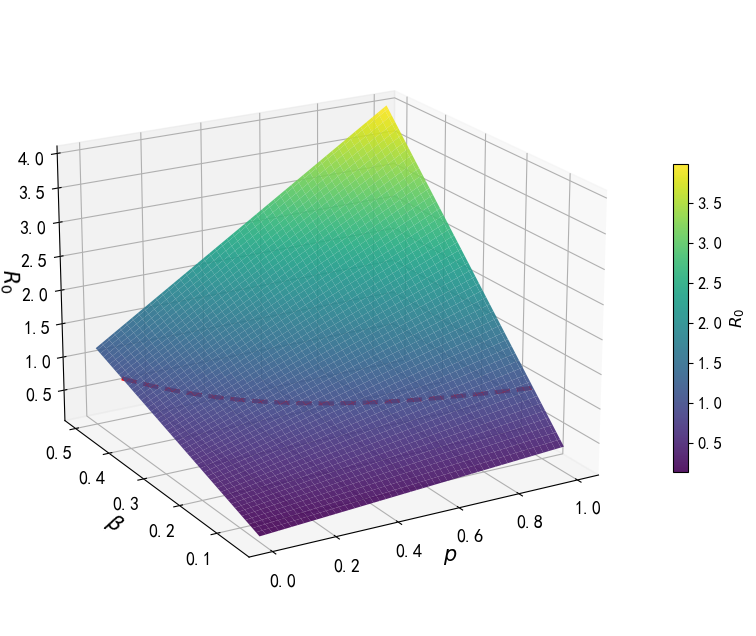

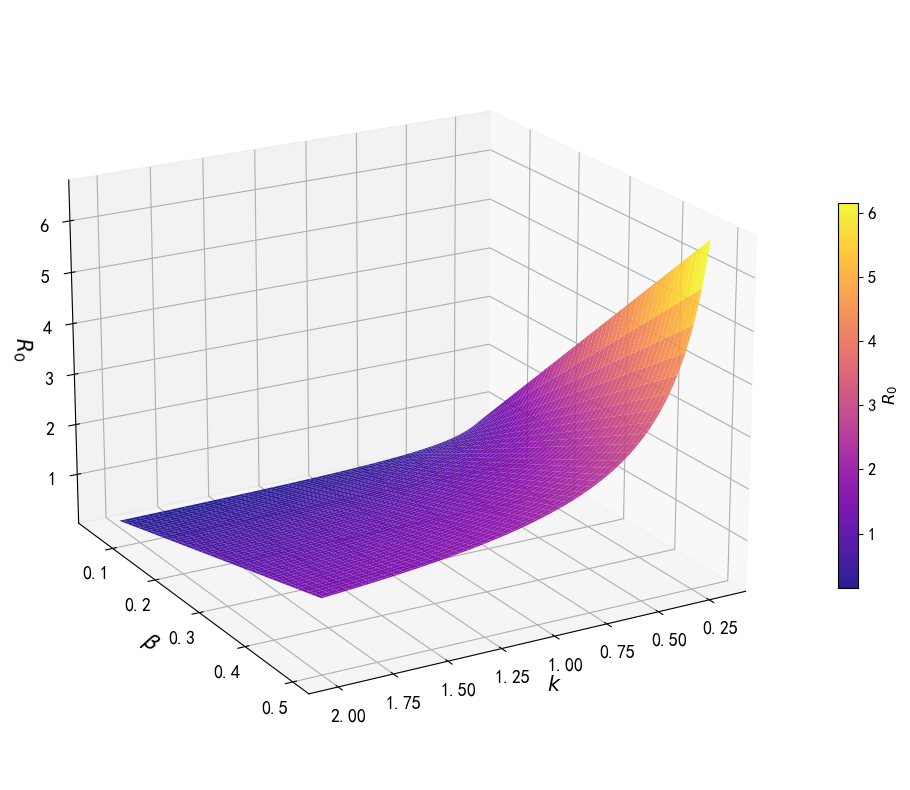

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
# 请确保您的环境中已安装 SimHei 字体，或者替换为您系统中的其他中文字体
try:
    mpl.rcParams['font.sans-serif'] = ['SimHei']
    mpl.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"未能设置中文字体，将使用默认字体。错误信息: {e}")


def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    此函数已向量化，可以直接处理Numpy数组。
    """
    # 使用 np.where 替换 if 语句，以处理数组输入并避免除以零
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.2,         # 基础传染率 (在3D图中将作为变量)
    'gamma': 1.0 / 7.0,  # 有症状感染者的恢复/隔离率
    'p': 0.4,            # 40% 的人未接种疫苗 (在3D图1中作为变量)
    'w': 0.3,            # 疫苗可使被感染的概率降低70% (w越小效力越强)
    'l': 0.5,            # 接种后感染转为无症状的比例
    'k': 0.8,            # 无症状者隔离率修正因子 (在3D图2中作为变量)
    'alpha': 1.2,        # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制两张三维图表 ---

# --- 图1 (改进版): R0 vs. 疫苗覆盖率(p) 和 传染率(beta) ---
fig1_3d = plt.figure(figsize=(12, 8))
ax1_3d = fig1_3d.add_subplot(111, projection='3d')

# 定义 p 和 beta 的范围
p_values = np.linspace(0, 1, 100)
beta_values = np.linspace(0.05, 0.5, 100)
P, BETA = np.meshgrid(p_values, beta_values)

# 计算 R0 曲面 (固定其他参数为基准值)
R0_surface1 = calculate_r0(
    beta=BETA,
    p=P,
    w=baseline_params['w'],
    l=baseline_params['l'],
    k=baseline_params['k'],
    alpha=baseline_params['alpha'],
    gamma=baseline_params['gamma']
)

# 绘制3D曲面
surf1 = ax1_3d.plot_surface(P, BETA, R0_surface1, cmap='viridis', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线，作为疫情爆发的临界线
ax1_3d.contour(P, BETA, R0_surface1, levels=[1.0], colors='red', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax1_3d.set_xlabel(r'$p$', fontsize=15, labelpad=2)
ax1_3d.set_ylabel(r'$\beta$', fontsize=15, labelpad=4)
ax1_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=2)
# ax1_3d.set_title('R0 作为疫苗覆盖率和传染率的函数', fontsize=16)

# 获取colorbar对象并设置其刻度字体大小
cb1 = fig1_3d.colorbar(surf1, shrink=0.5, aspect=20)
cb1.ax.tick_params(labelsize=12)
cb1.set_label(r'$R_0$', size=12) # 也可以顺便调整colorbar本身的标签大小

# 设置坐标轴刻度数字大小
tick_font_size = 13
ax1_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax1_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax1_3d.zaxis.set_tick_params(labelsize=tick_font_size)

# 调整初始视角，便于观察
ax1_3d.view_init(elev=20, azim=-120) 


# --- 图2 (改进版): R0 vs. 无症状者隔离效率(k) 和 传染率(beta) ---
fig2_3d = plt.figure(figsize=(12, 8))
ax2_3d = fig2_3d.add_subplot(111, projection='3d')

# 定义 k 和 beta 的范围
k_values = np.linspace(0.2, 2.0, 100)
# beta_values 保持不变
K, BETA_k = np.meshgrid(k_values, beta_values)

# 计算 R0 曲面 (固定其他参数为基准值)
R0_surface2 = calculate_r0(
    beta=BETA_k,
    p=baseline_params['p'],
    w=baseline_params['w'],
    l=baseline_params['l'],
    k=K,
    alpha=baseline_params['alpha'],
    gamma=baseline_params['gamma']
)

# 绘制3D曲面
surf2 = ax2_3d.plot_surface(K, BETA_k, R0_surface2, cmap='plasma', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线
ax2_3d.contour(K, BETA_k, R0_surface2, levels=[1.0], colors='white', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax2_3d.set_xlabel(r'$k$', fontsize=15, labelpad=2)
ax2_3d.set_ylabel(r'$\beta$', fontsize=15, labelpad=4)
ax2_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=2)
# ax2_3d.set_title('R0 作为无症状者隔离效率和传染率的函数', fontsize=16)

# 获取colorbar对象并设置其刻度字体大小
cb2 = fig2_3d.colorbar(surf2, shrink=0.5, aspect=20)
cb2.ax.tick_params(labelsize=12)
cb2.set_label(r'$R_0$', size=12)

# 设置坐标轴刻度数字大小
ax2_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax2_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax2_3d.zaxis.set_tick_params(labelsize=tick_font_size)

# 调整初始视角
ax2_3d.view_init(elev=20, azim=60)


# --- ↓↓↓ 这里是新添加的PDF保存代码 ↓↓↓ ---
print("正在将图像保存为PDF文件...")

# 保存图1
fig1_3d.savefig("R0_vs_p_and_beta_3D.pdf", bbox_inches='tight')

# 保存图2
fig2_3d.savefig("R0_vs_k_and_beta_3D.pdf", bbox_inches='tight')

print("PDF文件已成功保存。")
# --- ↑↑↑ PDF保存代码结束 ↑↑↑ ---


# 显示所有图像
plt.tight_layout()
plt.show()

In [ ]:
#改进z轴

正在将图像保存为PDF文件...
PDF文件已成功保存。


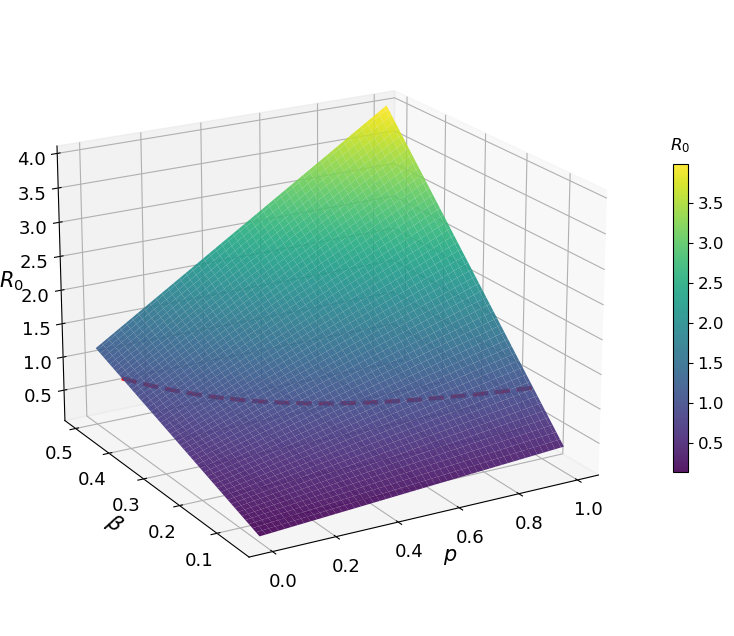

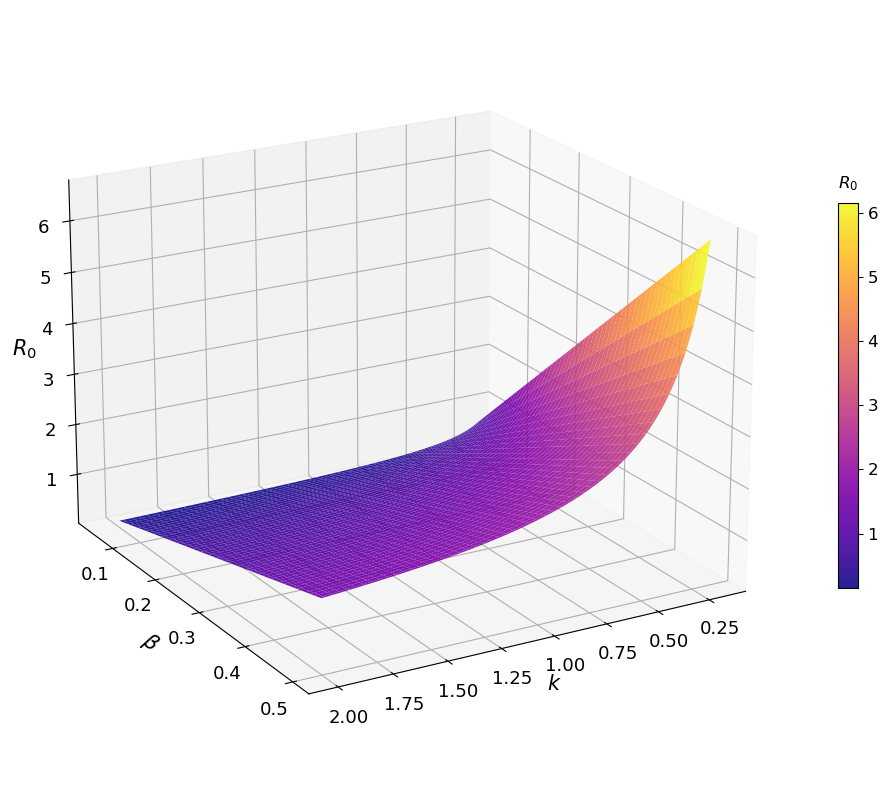

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
# 请确保您的环境中已安装 SimHei 字体，或者替换为您系统中的其他中文字体
# try:
#     mpl.rcParams['font.sans-serif'] = ['SimHei']
#     mpl.rcParams['axes.unicode_minus'] = False
# except Exception as e:
#     print(f"未能设置中文字体，将使用默认字体。错误信息: {e}")


def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    此函数已向量化，可以直接处理Numpy数组。
    """
    # 使用 np.where 替换 if 语句，以处理数组输入并避免除以零
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.2,         # 基础传染率 (在3D图中将作为变量)
    'gamma': 1.0 / 7.0,  # 有症状感染者的恢复/隔离率
    'p': 0.4,            # 40% 的人未接종疫苗 (在3D图1中作为变量)
    'w': 0.3,            # 疫苗可使被感染的概率降低70% (w越小效力越强)
    'l': 0.5,            # 接种后感染转为无症状的比例
    'k': 0.8,            # 无症状者隔离率修正因子 (在3D图2中作为变量)
    'alpha': 1.2,        # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制两张三维图表 ---

# --- 图1 (保持原样) ---
fig1_3d = plt.figure(figsize=(12, 8))
ax1_3d = fig1_3d.add_subplot(111, projection='3d')

p_values = np.linspace(0, 1, 100)
beta_values = np.linspace(0.05, 0.5, 100)
P, BETA = np.meshgrid(p_values, beta_values)

R0_surface1 = calculate_r0(
    beta=BETA, p=P, w=baseline_params['w'], l=baseline_params['l'],
    k=baseline_params['k'], alpha=baseline_params['alpha'], gamma=baseline_params['gamma']
)

surf1 = ax1_3d.plot_surface(P, BETA, R0_surface1, cmap='viridis', edgecolor='none', alpha=0.9)
ax1_3d.contour(P, BETA, R0_surface1, levels=[1.0], colors='red', linewidths=3, linestyles="--")

ax1_3d.set_xlabel(r'$p$', fontsize=15, labelpad=2)
ax1_3d.set_ylabel(r'$\beta$', fontsize=15, labelpad=4)
# ax1_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=2)
# 1. 设置Z轴标签，并增大labelpad为标签留出空间
ax1_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=1) 
# 2. 禁止标签随视图自动旋转
ax1_3d.zaxis.set_rotate_label(False)
# 3. 将标签文字旋转0度，使其水平显示
ax1_3d.zaxis.label.set_rotation(0)

cb1 = fig1_3d.colorbar(surf1, shrink=0.5, aspect=20)
cb1.ax.tick_params(labelsize=12)
# cb1.set_label(r'$R_0$', size=12)
# cb1.set_label(r'$R_0$', size=12, rotation=0, labelpad=15)
cb1.ax.set_title(r'$R_0$', size=12, pad=10)

tick_font_size = 13
ax1_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax1_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax1_3d.zaxis.set_tick_params(labelsize=tick_font_size)

ax1_3d.view_init(elev=20, azim=-120) 


# --- 图2 (应用修改) ---
fig2_3d = plt.figure(figsize=(12, 8))
ax2_3d = fig2_3d.add_subplot(111, projection='3d')

k_values = np.linspace(0.2, 2.0, 100)
K, BETA_k = np.meshgrid(k_values, beta_values)

R0_surface2 = calculate_r0(
    beta=BETA_k, p=baseline_params['p'], w=baseline_params['w'],
    l=baseline_params['l'], k=K, alpha=baseline_params['alpha'], gamma=baseline_params['gamma']
)

surf2 = ax2_3d.plot_surface(K, BETA_k, R0_surface2, cmap='plasma', edgecolor='none', alpha=0.9)
ax2_3d.contour(K, BETA_k, R0_surface2, levels=[1.0], colors='white', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax2_3d.set_xlabel(r'$k$', fontsize=15, labelpad=2)
ax2_3d.set_ylabel(r'$\beta$', fontsize=15, labelpad=4)

# --- ↓↓↓ 这里是您要求的修改 ↓↓↓ ---
# 1. 设置Z轴标签，并增大labelpad为标签留出空间
ax2_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=1) 
# 2. 禁止标签随视图自动旋转
ax2_3d.zaxis.set_rotate_label(False)
# 3. 将标签文字旋转0度，使其水平显示
ax2_3d.zaxis.label.set_rotation(0)
# --- ↑↑↑ 修改结束 ↑↑↑ ---

cb2 = fig2_3d.colorbar(surf2, shrink=0.5, aspect=20)
cb2.ax.tick_params(labelsize=12)
# cb2.set_label(r'$R_0$', size=12)
# cb2.set_label(r'$R_0$', size=12, rotation=0, labelpad=15)
# 将标签设置为Colorbar的标题，放置在顶端
cb2.ax.set_title(r'$R_0$', size=12, pad=10)

# 设置坐标轴刻度数字大小
ax2_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax2_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax2_3d.zaxis.set_tick_params(labelsize=tick_font_size)

# 调整初始视角
ax2_3d.view_init(elev=20, azim=60)


# --- ↓↓↓ 这里是新添加的PDF保存代码 ↓↓↓ ---
print("正在将图像保存为PDF文件...")

# 保存图1
fig1_3d.savefig("R0_vs_p_and_beta_3D.pdf", bbox_inches='tight')

# 保存图2
fig2_3d.savefig("R0_vs_k_and_beta_3D.pdf", bbox_inches='tight')

print("PDF文件已成功保存。")
# --- ↑↑↑ PDF保存代码结束 ↑↑↑ ---

# 显示所有图像
plt.tight_layout()
plt.show()

正在将图像保存为PDF文件...
PDF文件已成功保存。


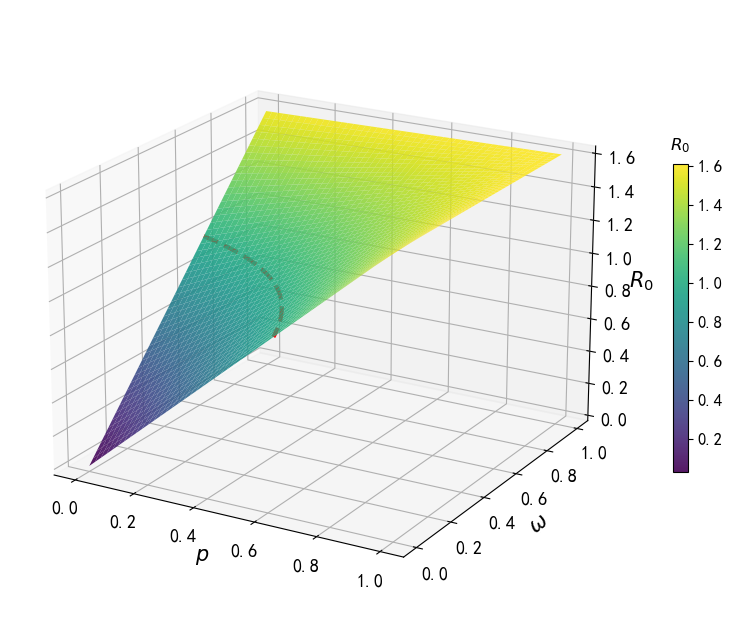

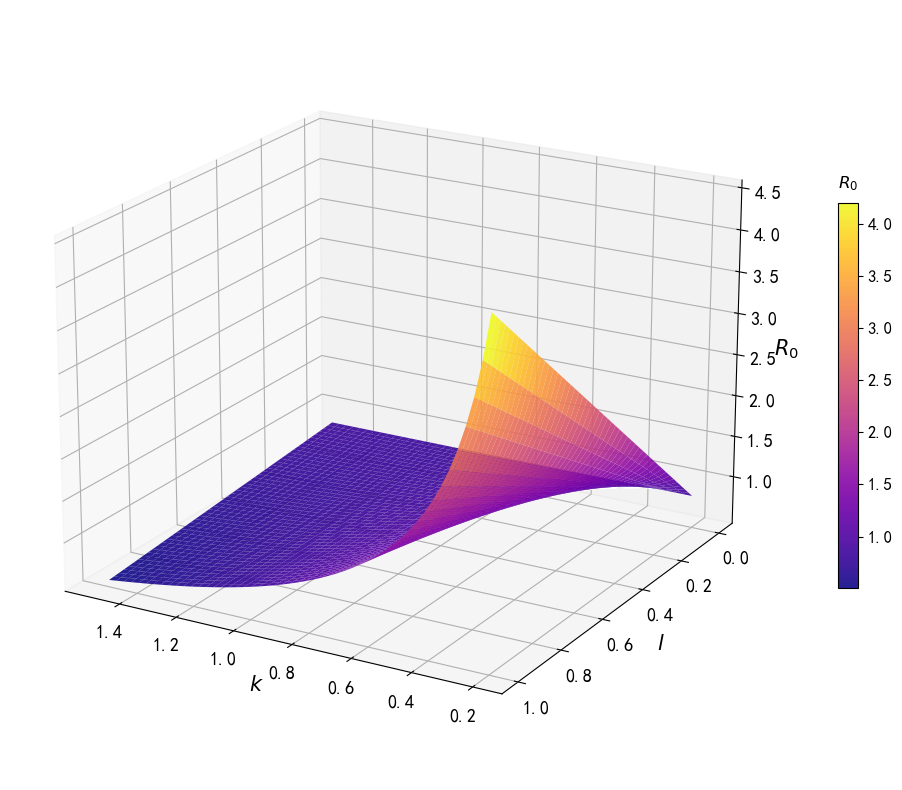

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
try:
    mpl.rcParams['font.sans-serif'] = ['SimHei']
    mpl.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"未能设置中文字体，将使用默认字体。错误信息: {e}")

def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    """
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.2,         # 基础传染率
    'gamma': 1.0 / 7.0,  # 有症状感染者的恢复/隔离率
    'p': 0.4,            # 40% 的人未接种疫苗
    'w': 0.3,            # 疫苗可使被感染的概率降低70%
    'l': 0.5,            # 接种后50%转为无症状
    'k': 0.8,            # 无症状者隔离率修正因子
    'alpha': 1.2,        # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制两张三维图表 ---

# --- 图3 (3D版): R0 vs. p 和 w ---
fig3_3d = plt.figure(figsize=(12, 8))
ax3_3d = fig3_3d.add_subplot(111, projection='3d')

# 数据网格生成 (与热图代码相同)
p_grid = np.linspace(0, 1, 50)
w_grid = np.linspace(0, 1, 50)
P, W = np.meshgrid(p_grid, w_grid)

R0_grid = calculate_r0(beta=baseline_params['beta'], k=baseline_params['k'], gamma=baseline_params['gamma'], 
                       p=P, l=baseline_params['l'], alpha=baseline_params['alpha'], w=W)

# 绘制3D曲面
surf3 = ax3_3d.plot_surface(P, W, R0_grid, cmap='viridis', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线
ax3_3d.contour(P, W, R0_grid, levels=[1.0], colors='red', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax3_3d.set_xlabel(r'$p$', fontsize=15, labelpad=2)
ax3_3d.set_ylabel(r'$\omega$', fontsize=15, labelpad=4)
# ax3_3d.set_zlabel(r'$R_0$',fontsize=15, labelpad=2)
# ax3_3d.set_title('R0 作为疫苗覆盖率和效力的函数 (3D)', fontsize=16)
# 1. 设置Z轴标签，并增大labelpad为标签留出空间
ax3_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=1) 
# 2. 禁止标签随视图自动旋转
ax3_3d.zaxis.set_rotate_label(False)
# 3. 将标签文字旋转0度，使其水平显示
ax3_3d.zaxis.label.set_rotation(0)

# fig3_3d.colorbar(surf3, shrink=0.5, aspect=20, label=r'$R_0$')

cb3 = fig3_3d.colorbar(surf3, shrink=0.5, aspect=20)
cb3.ax.tick_params(labelsize=12)
# cb2.set_label(r'$R_0$', size=12)
# cb2.set_label(r'$R_0$', size=12, rotation=0, labelpad=15)
# 将标签设置为Colorbar的标题，放置在顶端
cb3.ax.set_title(r'$R_0$', size=12, pad=10)

ax3_3d.view_init(elev=20, azim=-60)


# --- 图4 (3D版): R0 vs. k 和 l ---
fig4_3d = plt.figure(figsize=(12, 8))
ax4_3d = fig4_3d.add_subplot(111, projection='3d')

# 数据网格生成 (与热图代码相同)
k_grid = np.linspace(0.2, 1.5, 50)
l_grid = np.linspace(0, 1, 50)
K, L = np.meshgrid(k_grid, l_grid)

R0_grid_kl = calculate_r0(beta=baseline_params['beta'], k=K, gamma=baseline_params['gamma'], 
                          p=baseline_params['p'], l=L, alpha=baseline_params['alpha'], w=baseline_params['w'])

# 绘制3D曲面
surf4 = ax4_3d.plot_surface(K, L, R0_grid_kl, cmap='plasma', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线
ax4_3d.contour(K, L, R0_grid_kl, levels=[1.0], colors='white', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax4_3d.set_xlabel(r'$k$', fontsize=15, labelpad=2)
ax4_3d.set_ylabel(r'$l$', fontsize=15, labelpad=4)
# ax4_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=2)
# ax4_3d.set_title('R0 作为无症状传播动态的函数 (3D)', fontsize=16)

# 1. 设置Z轴标签，并增大labelpad为标签留出空间
ax4_3d.set_zlabel(r'$R_0$', fontsize=15, labelpad=1) 
# 2. 禁止标签随视图自动旋转
ax4_3d.zaxis.set_rotate_label(False)
# 3. 将标签文字旋转0度，使其水平显示
ax4_3d.zaxis.label.set_rotation(0)

# fig4_3d.colorbar(surf4, shrink=0.5, aspect=20, label=r'$R_0$')

cb4 = fig4_3d.colorbar(surf4, shrink=0.5, aspect=20)
cb4.ax.tick_params(labelsize=12)
# cb2.set_label(r'$R_0$', size=12)
# cb2.set_label(r'$R_0$', size=12, rotation=0, labelpad=15)
# 将标签设置为Colorbar的标题，放置在顶端
cb4.ax.set_title(r'$R_0$', size=12, pad=10)

ax4_3d.view_init(elev=20, azim=120)

tick_font_size = 13
ax3_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax3_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax3_3d.zaxis.set_tick_params(labelsize=tick_font_size)

ax4_3d.xaxis.set_tick_params(labelsize=tick_font_size)
ax4_3d.yaxis.set_tick_params(labelsize=tick_font_size)
ax4_3d.zaxis.set_tick_params(labelsize=tick_font_size)

print("正在将图像保存为PDF文件...")

# 保存图3
fig3_3d.savefig("R0_surface_p_vs_w.pdf", bbox_inches='tight')

# 保存图4
fig4_3d.savefig("R0_surface_k_vs_l.pdf", bbox_inches='tight')

print("PDF文件已成功保存。")

plt.tight_layout()
plt.show()

正在将图像保存为PDF文件...
PDF文件已成功保存。


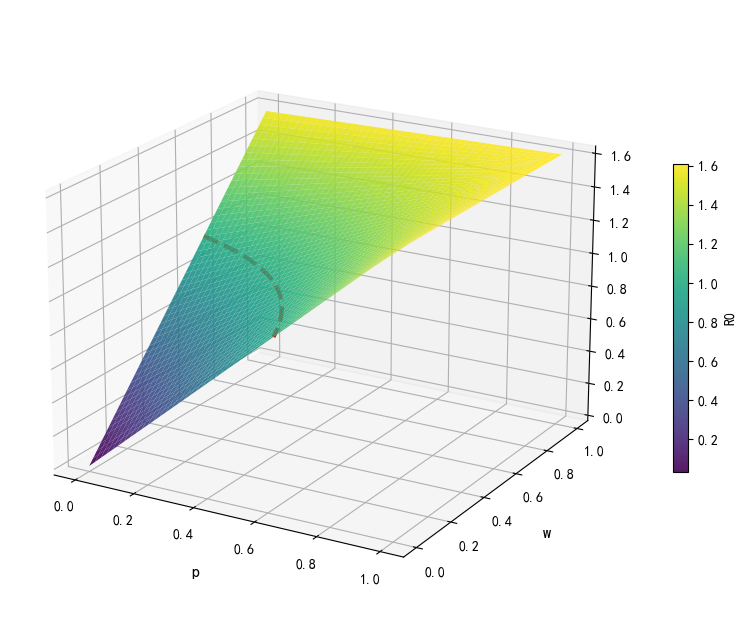

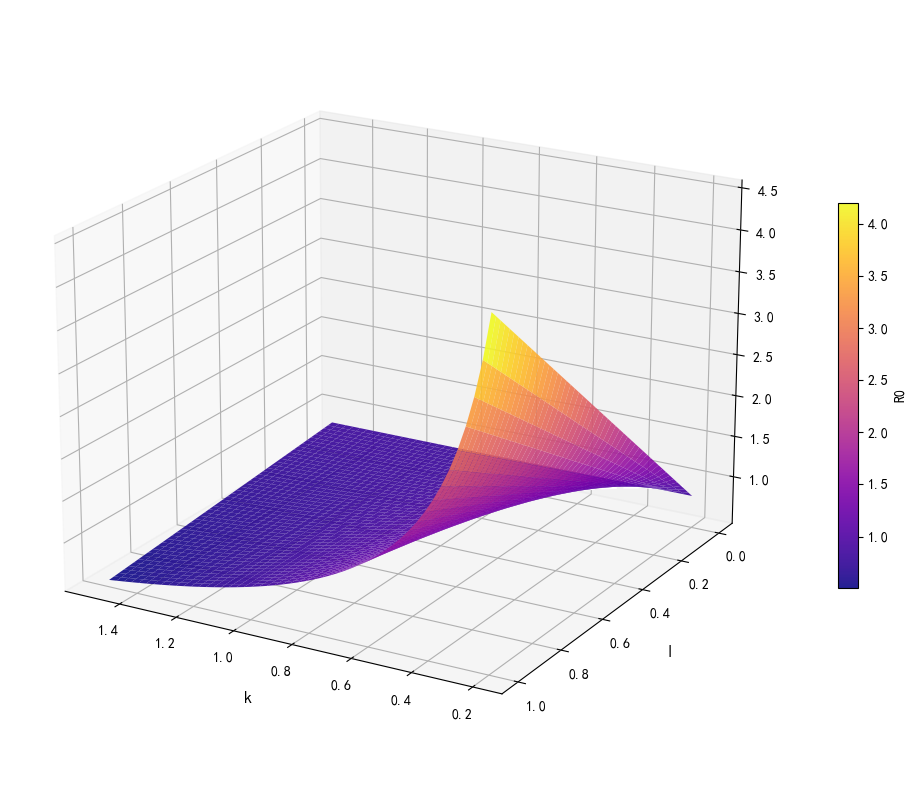

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# --- 准备工作: 定义函数和基准参数 ---

# 设置全局字体以支持中文显示
try:
    mpl.rcParams['font.sans-serif'] = ['SimHei']
    mpl.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"未能设置中文字体，将使用默认字体。错误信息: {e}")

def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    根据最终确定的SEIAQ模型图计算R0。
    """
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组基准参数，用于在每次分析中固定其他变量
baseline_params = {
    'beta': 0.2,         # 基础传染率
    'gamma': 1.0 / 7.0,  # 有症状感染者的恢复/隔离率
    'p': 0.4,            # 40% 的人未接种疫苗
    'w': 0.3,            # 疫苗可使被感染的概率降低70%
    'l': 0.5,            # 接种后50%转为无症状
    'k': 0.8,            # 无症状者隔离率修正因子
    'alpha': 1.2,        # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 分析开始：绘制两张三维图表 ---

# --- 图3 (3D版): R0 vs. p 和 w ---
fig3_3d = plt.figure(figsize=(12, 8))
ax3_3d = fig3_3d.add_subplot(111, projection='3d')

# 数据网格生成 (与热图代码相同)
p_grid = np.linspace(0, 1, 50)
w_grid = np.linspace(0, 1, 50)
P, W = np.meshgrid(p_grid, w_grid)

R0_grid = calculate_r0(beta=baseline_params['beta'], k=baseline_params['k'], gamma=baseline_params['gamma'], 
                       p=P, l=baseline_params['l'], alpha=baseline_params['alpha'], w=W)

# 绘制3D曲面
surf3 = ax3_3d.plot_surface(P, W, R0_grid, cmap='viridis', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线
ax3_3d.contour(P, W, R0_grid, levels=[1.0], colors='red', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax3_3d.set_xlabel('p', fontsize=12, labelpad=10)
ax3_3d.set_ylabel('w', fontsize=12, labelpad=10)
# ax3_3d.set_zlabel('R0',fontsize=12, labelpad=10)
# ax3_3d.set_title('R0 作为疫苗覆盖率和效力的函数 (3D)', fontsize=16)
fig3_3d.colorbar(surf3, shrink=0.5, aspect=20, label='R0')
ax3_3d.view_init(elev=20, azim=-60)


# --- 图4 (3D版): R0 vs. k 和 l ---
fig4_3d = plt.figure(figsize=(12, 8))
ax4_3d = fig4_3d.add_subplot(111, projection='3d')

# 数据网格生成 (与热图代码相同)
k_grid = np.linspace(0.2, 1.5, 50)
l_grid = np.linspace(0, 1, 50)
K, L = np.meshgrid(k_grid, l_grid)

R0_grid_kl = calculate_r0(beta=baseline_params['beta'], k=K, gamma=baseline_params['gamma'], 
                          p=baseline_params['p'], l=L, alpha=baseline_params['alpha'], w=baseline_params['w'])

# 绘制3D曲面
surf4 = ax4_3d.plot_surface(K, L, R0_grid_kl, cmap='plasma', edgecolor='none', alpha=0.9)

# 在曲面上添加 R0 = 1 的等高线
ax4_3d.contour(K, L, R0_grid_kl, levels=[1.0], colors='white', linewidths=3, linestyles="--")

# 设置坐标轴标签和标题
ax4_3d.set_xlabel('k', fontsize=12, labelpad=10)
ax4_3d.set_ylabel('l', fontsize=12, labelpad=10)
# ax4_3d.set_zlabel('R0', fontsize=12, labelpad=10)
# ax4_3d.set_title('R0 作为无症状传播动态的函数 (3D)', fontsize=16)
fig4_3d.colorbar(surf4, shrink=0.5, aspect=20, label='R0')
ax4_3d.view_init(elev=20, azim=120)


# --- ↓↓↓ 这里是新添加的PDF保存代码 ↓↓↓ ---
print("正在将图像保存为PDF文件...")

# 保存图3
fig3_3d.savefig("R0_surface_p_vs_w.pdf", bbox_inches='tight')

# 保存图4
fig4_3d.savefig("R0_surface_k_vs_l.pdf", bbox_inches='tight')

print("PDF文件已成功保存。")
# --- ↑↑↑ PDF保存代码结束 ↑↑↑ ---


plt.tight_layout()
plt.show()

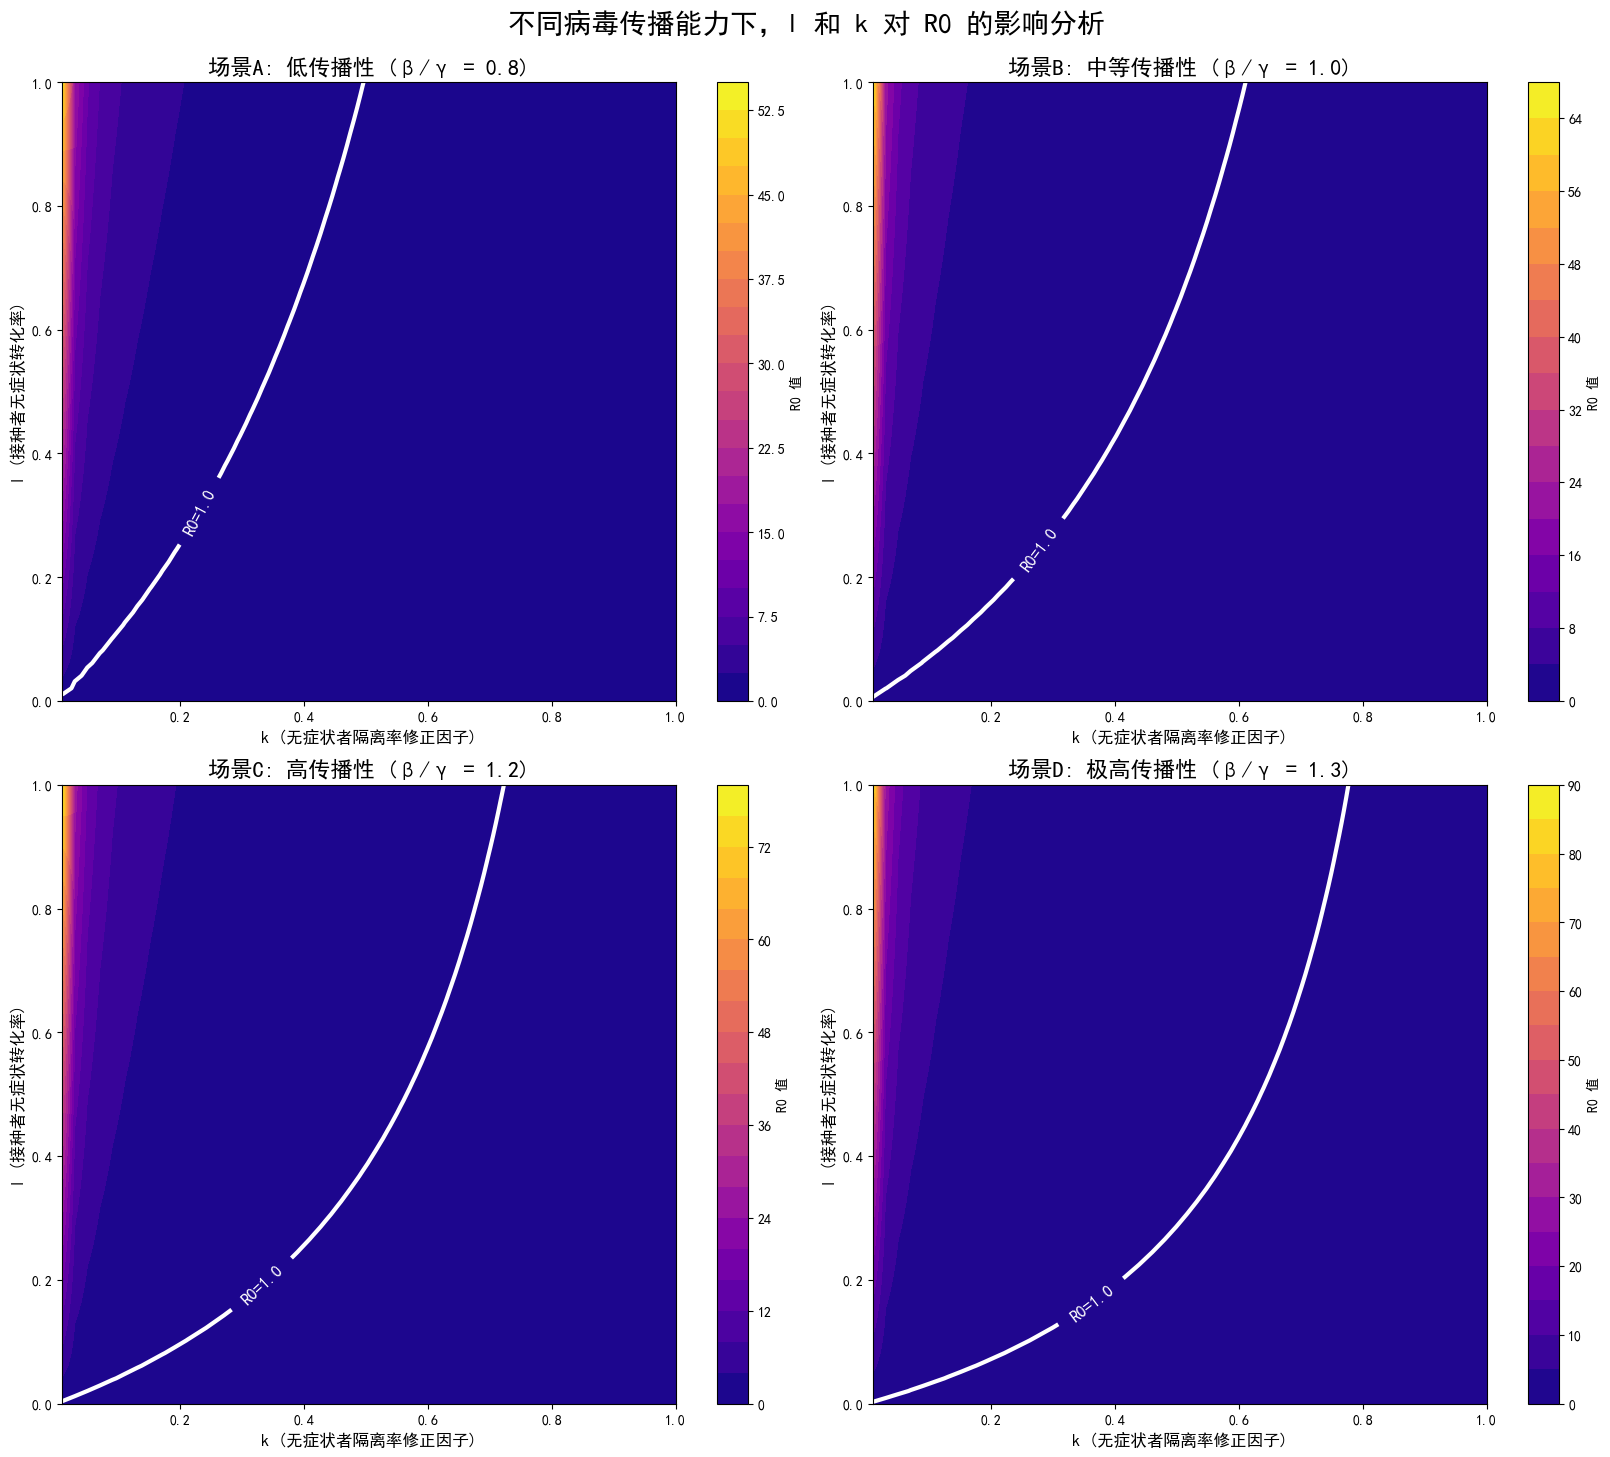

In [4]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和通用参数 ---

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    矢量化版本的R0计算函数，能够处理数组输入。
    """
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# --- ↓↓↓ 这里是唯一的修改 ↓↓↓ ---
# 设定一组在各个场景中保持不变的基准参数
# (已将 gamma 从字典中移除)
baseline_params = {
    'p': 0.4,              # 40% 的人未接种疫苗
    'w': 0.3,              # 疫苗可使被感染的概率降低70%
    'alpha': 1.2,          # 未接种者成为无症状的比例是接种者的1.2倍
}
# --- ↑↑↑ 这里是唯一的修改 ↑↑↑ ---


# --- 核心分析: 创建并循环四种场景 ---

# 1. 定义四个场景的beta值和标题
gamma_val = 1.0 / 7.0 # 单独定义 gamma
scenarios = {
    f'场景A: 低传播性 (β/γ = 0.8)': 0.8 * gamma_val,
    f'场景B: 中等传播性 (β/γ = 1.0)': 1.0 * gamma_val,
    f'场景C: 高传播性 (β/γ = 1.2)': 1.2 * gamma_val,
    f'场景D: 极高传播性 (β/γ = 1.3)': 1.3 * gamma_val,
}

# 2. 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(16, 14), constrained_layout=True)
axes = axes.flatten()

# 3. 循环每个场景并绘图
for i, (title, beta_val) in enumerate(scenarios.items()):
    ax = axes[i] 
    
    k_grid = np.linspace(0.01, 1.0, 50)
    l_grid = np.linspace(0, 1, 50)
    K, L = np.meshgrid(k_grid, l_grid)
    
    # R0_grid 的计算函数调用不再有冲突
    R0_grid = calculate_r0(beta=beta_val, k=K, gamma=gamma_val, l=L, **baseline_params)

    contourf = ax.contourf(K, L, R0_grid, levels=20, cmap='plasma')
    fig.colorbar(contourf, ax=ax, label='R0 值')

    try:
        contour_line = ax.contour(K, L, R0_grid, levels=[1.0], colors='white', linewidths=3)
        ax.clabel(contour_line, inline=True, fontsize=12, fmt='R0=%.1f')
    except ValueError:
        ax.text(0.5, 0.5, 'R0 > 1\n(无法控制)', color='white', ha='center', va='center', fontsize=18, transform=ax.transAxes)

    ax.set_xlabel('k (无症状者隔离率修正因子)', fontsize=12)
    ax.set_ylabel('l (接种者无症状转化率)', fontsize=12)
    ax.set_title(title, fontsize=16)
    
fig.savefig("不同病毒传播能力下，l 和 k 对 R0 的影响分析.pdf", bbox_inches='tight')

fig.suptitle('不同病毒传播能力下，l 和 k 对 R0 的影响分析', fontsize=20, y=1.03)

plt.show()

正在生成四张场景图...
所有图像已生成完毕，即将显示...


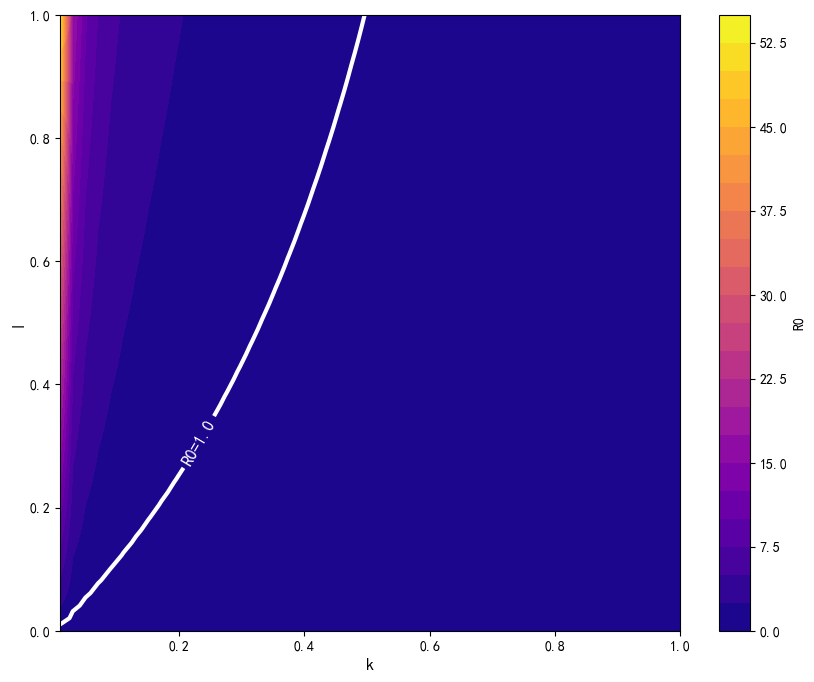

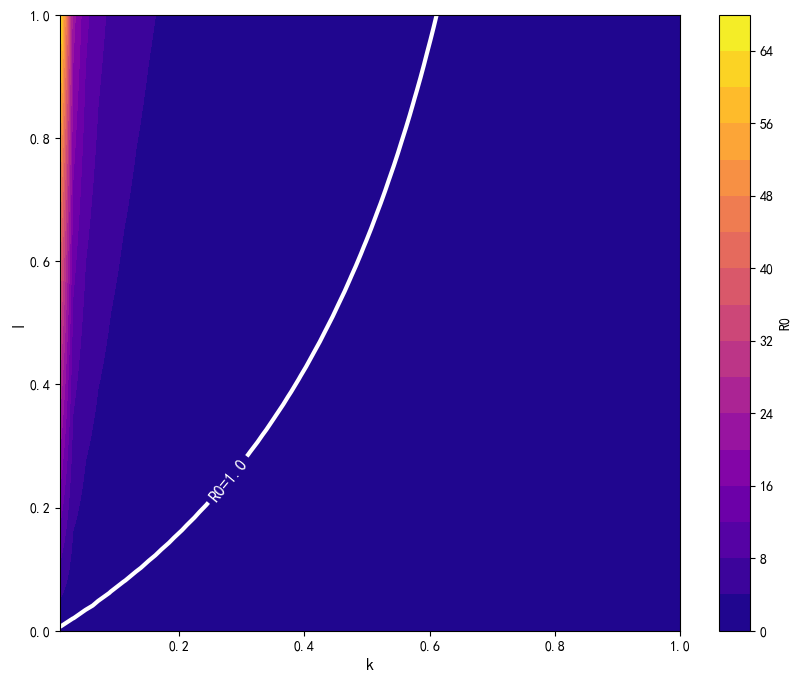

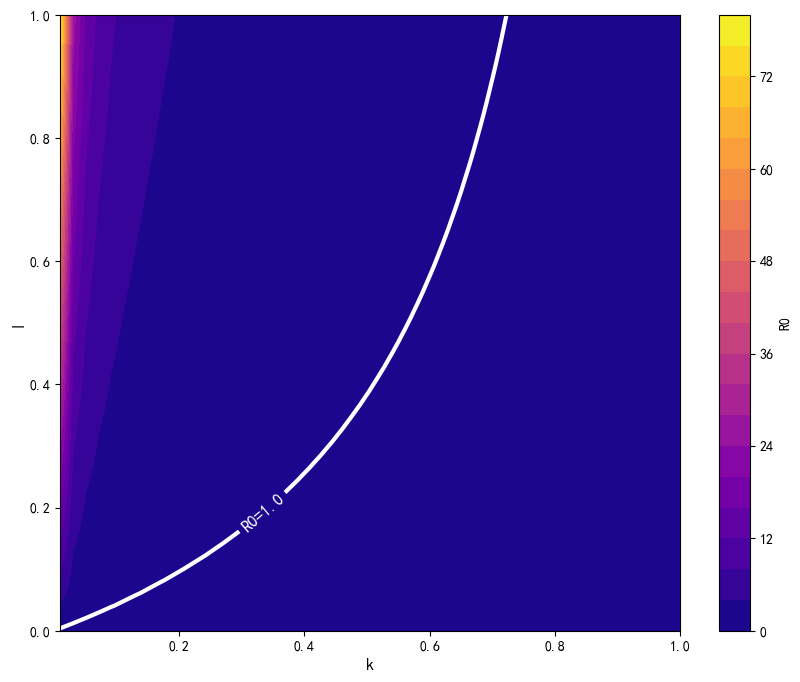

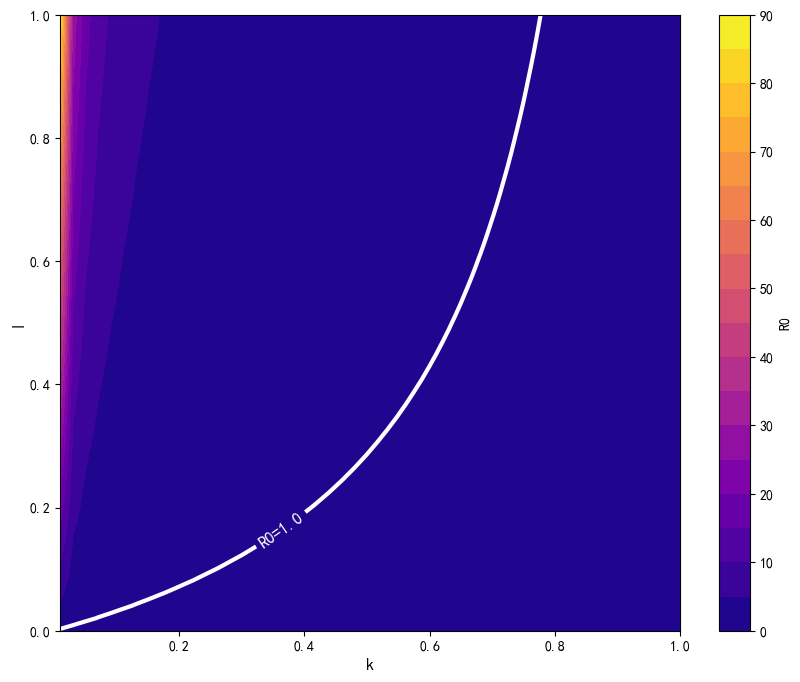

In [26]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和通用参数 ---

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    矢量化版本的R0计算函数，能够处理数组输入。
    """
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组在各个场景中保持不变的基准参数
baseline_params = {
    'p': 0.4,           # 40% 的人未接种疫苗
    'w': 0.3,           # 疫苗可使被感染的概率降低70%
    'alpha': 1.2,       # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 核心分析: 创建并循环四种场景 ---

# 1. 定义四个场景的beta值和标题
gamma_val = 1.0 / 7.0 # 单独定义 gamma
# scenarios = {
#     f'场景A: 低传播性 (β/γ = 0.8)': 0.8 * gamma_val,
#     f'场景B: 中等传播性 (β/γ = 1.0)': 1.0 * gamma_val,
#     f'场景C: 高传播性 (β/γ = 1.2)': 1.2 * gamma_val,
#     f'场景D: 极高传播性 (β/γ = 1.3)': 1.3 * gamma_val,
# }


# 2. 循环每个场景并单独绘图
print("正在生成四张场景图...")
for title, beta_val in scenarios.items():
    
    # 为每个场景创建独立的图窗和坐标轴
    fig, ax = plt.subplots(figsize=(10, 8)) 
    
    # 数据网格生成
    k_grid = np.linspace(0.01, 1.0, 50)
    l_grid = np.linspace(0, 1, 50)
    K, L = np.meshgrid(k_grid, l_grid)
    
    R0_grid = calculate_r0(beta=beta_val, k=K, gamma=gamma_val, l=L, **baseline_params)

    # 绘图
    contourf = ax.contourf(K, L, R0_grid, levels=20, cmap='plasma')
    fig.colorbar(contourf, ax=ax, label='R0')

    try:
        contour_line = ax.contour(K, L, R0_grid, levels=[1.0], colors='white', linewidths=3)
        ax.clabel(contour_line, inline=True, fontsize=12, fmt='R0=%.1f')
    except ValueError:
        ax.text(0.5, 0.5, 'R0 始终 > 1\n(无法控制)', color='white', ha='center', va='center', fontsize=18, transform=ax.transAxes)

    # 设置标签和标题
    ax.set_xlabel('k', fontsize=12)
    ax.set_ylabel('l', fontsize=12)
#     ax.set_title(title, fontsize=16)

print("所有图像已生成完毕，即将显示...")

# --- ↓↓↓ 这里是唯一的修改 ↓↓↓ ---
# 在所有循环结束后，一次性显示所有创建的图窗
plt.show()
# --- ↑↑↑ 修改结束 ↑↑↑ ---

正在生成四张3D场景图...
所有3D图像已生成完毕，即将显示...


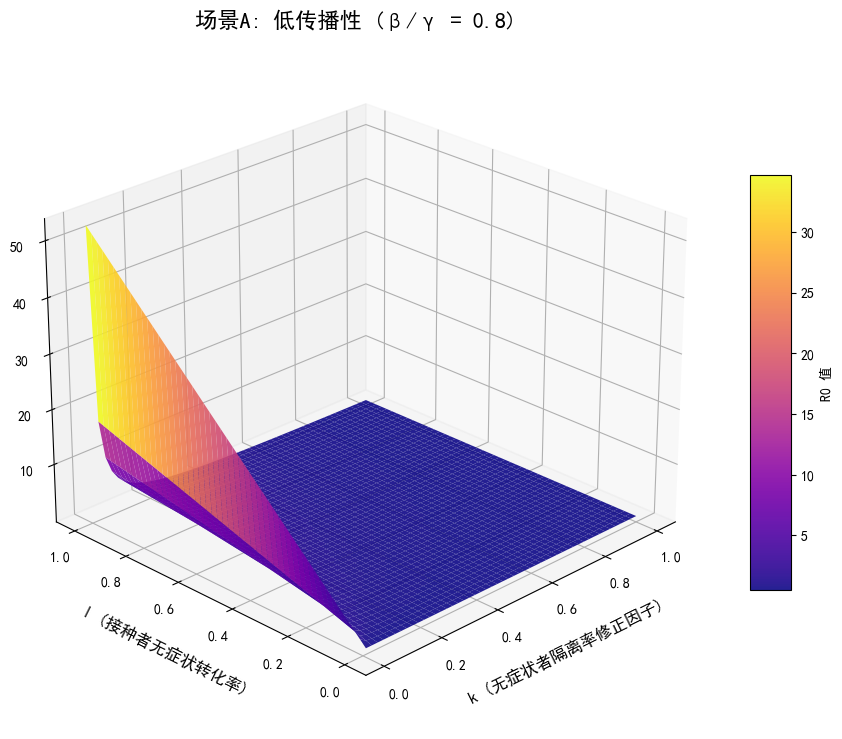

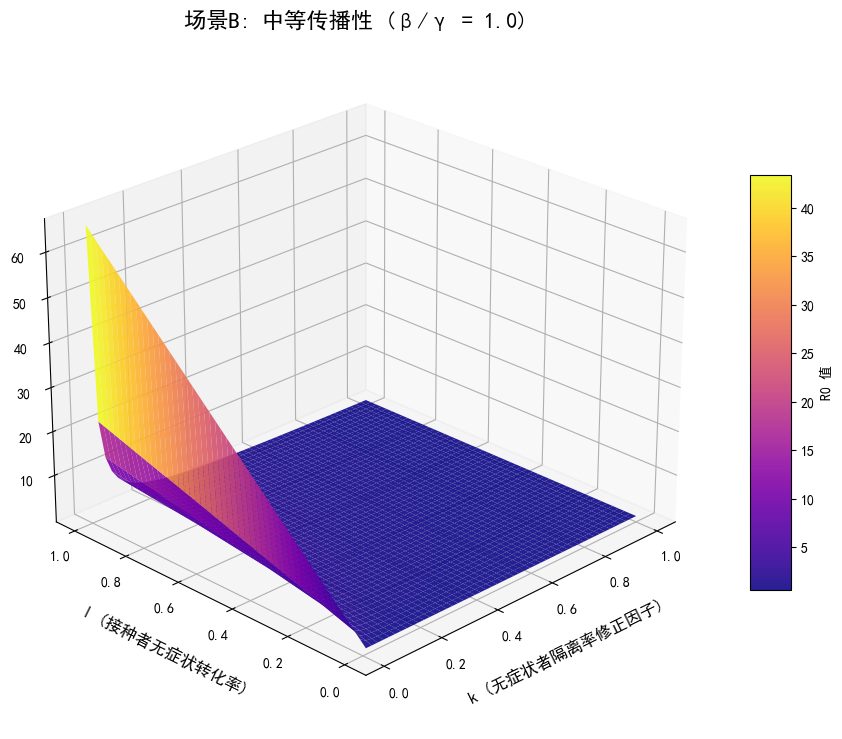

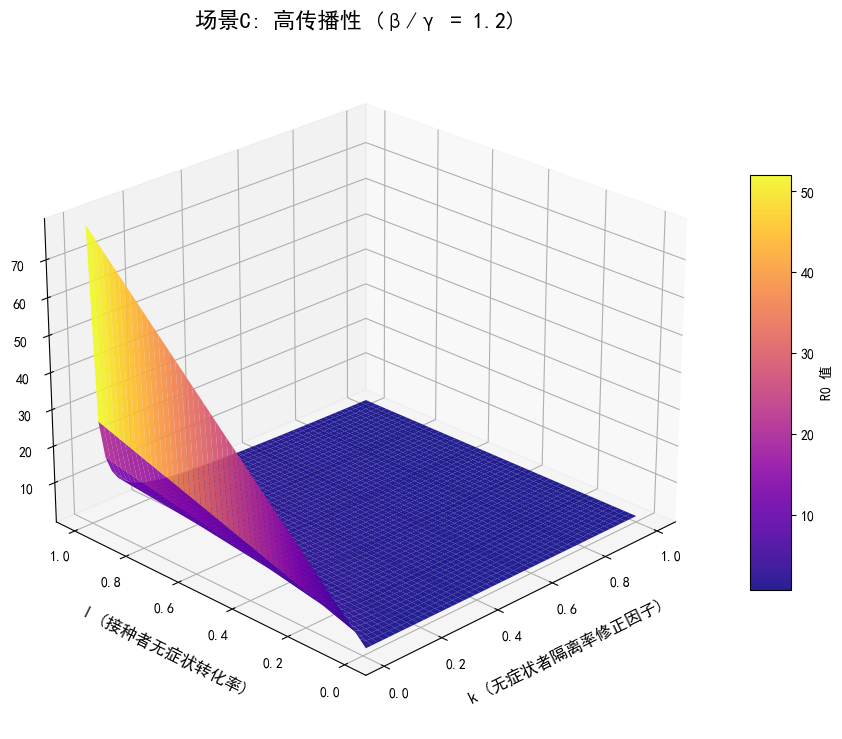

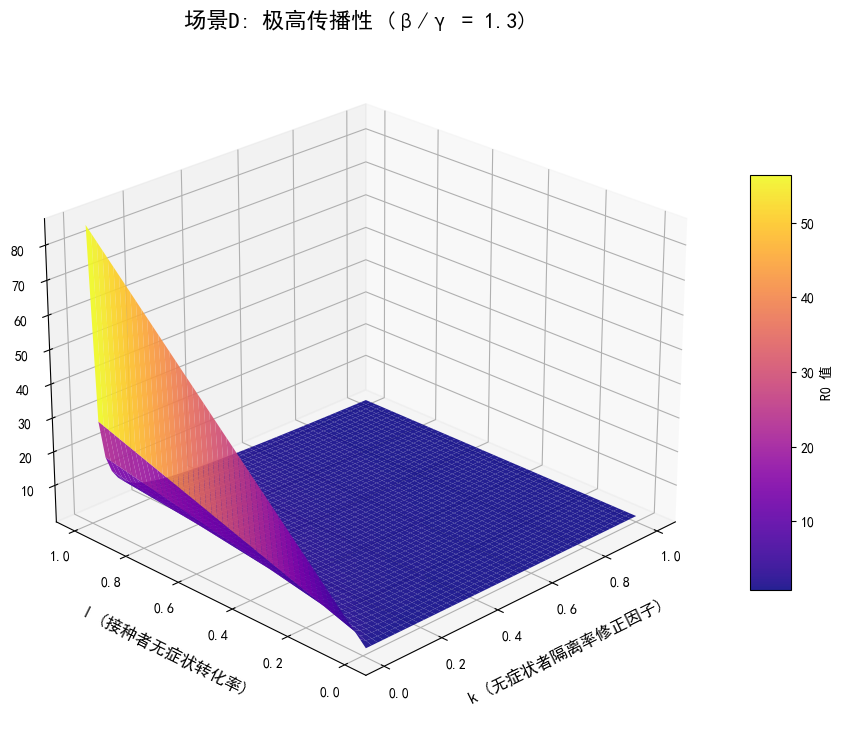

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D # <-- 1. Import the 3D toolkit

# --- 准备工作: 定义函数和通用参数 ---

# 设置全局字体以支持中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def calculate_r0(beta, p, w, l, k, alpha, gamma):
    """
    矢量化版本的R0计算函数，能够处理数组输入。
    """
    k = np.where(k <= 0, 1e-9, k)
    
    proportion_vaccinated = 1.0 - p
    
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# 设定一组在各个场景中保持不变的基准参数
baseline_params = {
    'p': 0.4,           # 40% 的人未接种疫苗
    'w': 0.3,           # 疫苗可使被感染的概率降低70%
    'alpha': 1.2,       # 未接种者成为无症状的比例是接种者的1.2倍
}


# --- 核心分析: 创建并循环四种场景 ---

# 1. 定义四个场景的beta值和标题
gamma_val = 1.0 / 7.0 # 单独定义 gamma
scenarios = {
    f'场景A: 低传播性 (β/γ = 0.8)': 0.8 * gamma_val,
    f'场景B: 中等传播性 (β/γ = 1.0)': 1.0 * gamma_val,
    f'场景C: 高传播性 (β/γ = 1.2)': 1.2 * gamma_val,
    f'场景D: 极高传播性 (β/γ = 1.3)': 1.3 * gamma_val,
}


# 2. 循环每个场景并单独绘制3D图
print("正在生成四张3D场景图...")
for title, beta_val in scenarios.items():
    
    # --- ↓↓↓ 这里是主要的修改区域 ↓↓↓ ---
    # 2.1 为每个场景创建独立的3D图窗
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    # --- ↑↑↑ 修改结束 ↑↑↑ ---
    
    # 数据网格生成
    k_grid = np.linspace(0.01, 1.0, 50)
    l_grid = np.linspace(0, 1, 50)
    K, L = np.meshgrid(k_grid, l_grid)
    
    R0_grid = calculate_r0(beta=beta_val, k=K, gamma=gamma_val, l=L, **baseline_params)

    # --- ↓↓↓ 这里是主要的修改区域 ↓↓↓ ---
    # 2.2 绘制3D曲面而不是contourf
    surf = ax.plot_surface(K, L, R0_grid, cmap='plasma', edgecolor='none', alpha=0.9)
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='R0 值')
    # --- ↑↑↑ 修改结束 ↑↑↑ ---

    try:
        # 在3D曲面上绘制 R0=1 的等高线
        contour_line = ax.contour(K, L, R0_grid, levels=[1.0], colors='white', linewidths=3, linestyles='--')
    except ValueError:
        # 如果R0始终大于1，无法绘制等高线，则在图的中间位置添加文字
        # 注意: 在3D中精确定位文字比较复杂，这里仅为示意
        ax.text2D(0.5, 0.5, 'R0 始终 > 1\n(无法控制)', color='white', ha='center', va='center', fontsize=18, transform=ax.transAxes)

    # --- ↓↓↓ 这里是主要的修改区域 ↓↓↓ ---
    # 2.3 设置三维坐标轴标签和视角
    ax.set_xlabel('k (无症状者隔离率修正因子)', fontsize=12, labelpad=10)
    ax.set_ylabel('l (接种者无症状转化率)', fontsize=12, labelpad=10)
    ax.set_zlabel('R0 基本再生数', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=16)
    ax.view_init(elev=25, azim=-135) # 设置一个合适的观察角度
    # --- ↑↑↑ 修改结束 ↑↑↑ ---

print("所有3D图像已生成完毕，即将显示...")

# 在所有循环结束后，一次性显示所有创建的图窗
plt.show()

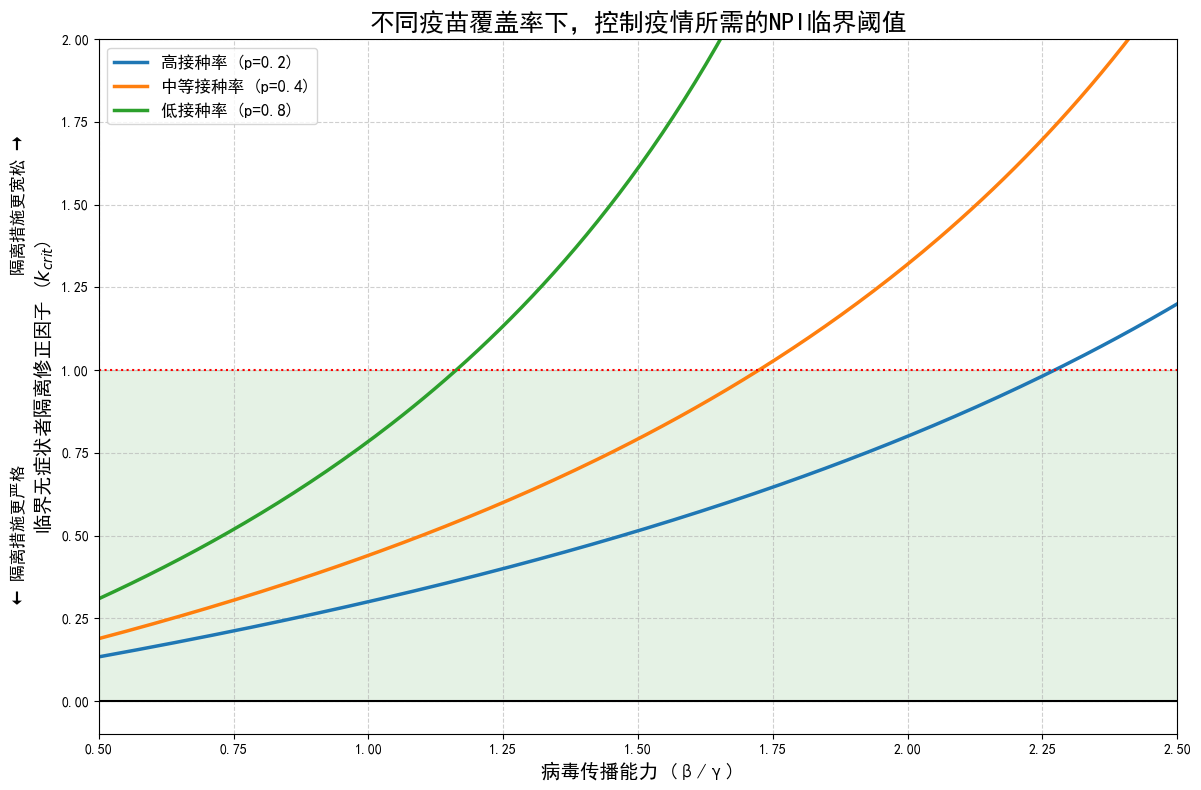

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和通用参数 ---

# 设置全局字体以支持中文显示和负号显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# R0计算函数 (保持不变)
def calculate_r0(beta, p, w, l, k, alpha, gamma):
    k = np.where(k <= 0, 1e-9, k)
    proportion_vaccinated = 1.0 - p
    term_unvaccinated = p * (l * alpha * (1 - k) + k)
    term_vaccinated = proportion_vaccinated * w * (l * (1 - k) + k)
    R0 = (beta / (k * gamma)) * (term_unvaccinated + term_vaccinated)
    return R0

# --- ↓↓↓ 新增的核心函数 ↓↓↓ ---
def calculate_k_critical(beta_gamma_ratio, p, w, l, alpha):
    """
    计算为了使R0=1，所需的临界k值 (k_crit)。
    该函数是根据 calculate_r0 方程 R0=1 推导出来的。
    """
    # 定义常数 M 和 C 以简化公式
    # C 代表与k无关的传播项 (总的无症状传播潜力)
    C = p * l * alpha + (1 - p) * w * l
    # M 代表与k相关的传播修正项
    M = p * (1 - l * alpha) + (1 - p) * w * (1 - l)

    # 从 R0 = beta_gamma_ratio * (M + C/k) = 1 推导k
    # k_crit = C / (1/beta_gamma_ratio - M)
    denominator = (1 / beta_gamma_ratio) - M
    
    # 如果分母小于等于0，意味着即使k=0（完美隔离），R0也无法降到1。
    # 这种情况表示疫情失控。我们返回一个标记值 (例如 nan)。
    k_crit = np.where(denominator > 0, C / denominator, np.nan)
    return k_crit
# --- ↑↑↑ 新增的核心函数结束 ↑↑↑ ---


# --- 核心分析: 临界控制阈值实验 ---

# 1. 设定固定的模拟参数
w_val = 0.3      # 疫苗防感染效力因子
l_val = 0.5      # 接种后转为无症状的比例
alpha_val = 1.2  # 未接种者成为无症状的比例修正

# 2. 定义不同的疫苗覆盖率情景
p_scenarios = {
    '高接种率 (p=0.2)': 0.2,  # 80%的人接种了疫苗
    '中等接种率 (p=0.4)': 0.4, # 60%的人接种了疫苗
    '低接种率 (p=0.8)': 0.8,  # 20%的人接种了疫苗
}

# 3. 创建图表
fig, ax = plt.subplots(figsize=(12, 8))

# 4. 定义X轴：病毒传播能力范围
beta_gamma_ratio_range = np.linspace(0.5, 2.5, 200)

# 5. 循环每个接种情景并绘图
for label, p_val in p_scenarios.items():
    k_crit_values = calculate_k_critical(beta_gamma_ratio_range, p=p_val, w=w_val, l=l_val, alpha=alpha_val)
    
    ax.plot(beta_gamma_ratio_range, k_crit_values, label=label, linewidth=2.5)

# 6. 完善图表细节
ax.set_xlabel('病毒传播能力 (β/γ)', fontsize=14)
ax.set_ylabel('临界无症状者隔离修正因子 ($k_{crit}$)', fontsize=14)
ax.set_title('不同疫苗覆盖率下，控制疫情所需的NPI临界阈值', fontsize=18)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# 添加参考线
ax.axhline(y=1.0, color='red', linestyle=':', label='k=1 (隔离效率同有症状者)')
ax.axhline(y=0.0, color='black', linestyle='-')
ax.fill_between(beta_gamma_ratio_range, 0, 1, color='green', alpha=0.1, label='NPI 可行区')

# Y轴代表隔离措施的严格程度，值越小越严格
ax.set_ylim(-0.1, 2.0)
ax.set_xlim(beta_gamma_ratio_range.min(), beta_gamma_ratio_range.max())

# 在Y轴添加解释性文本
ax.text(ax.get_xlim()[0] - 0.15, 0.5, '← 隔离措施更严格', va='center', ha='center', rotation='vertical', fontsize=12)
ax.text(ax.get_xlim()[0] - 0.15, 1.5, '隔离措施更宽松 →', va='center', ha='center', rotation='vertical', fontsize=12)

plt.tight_layout()
fig.savefig("NPI临界阈值分析.pdf", bbox_inches='tight')
plt.show()

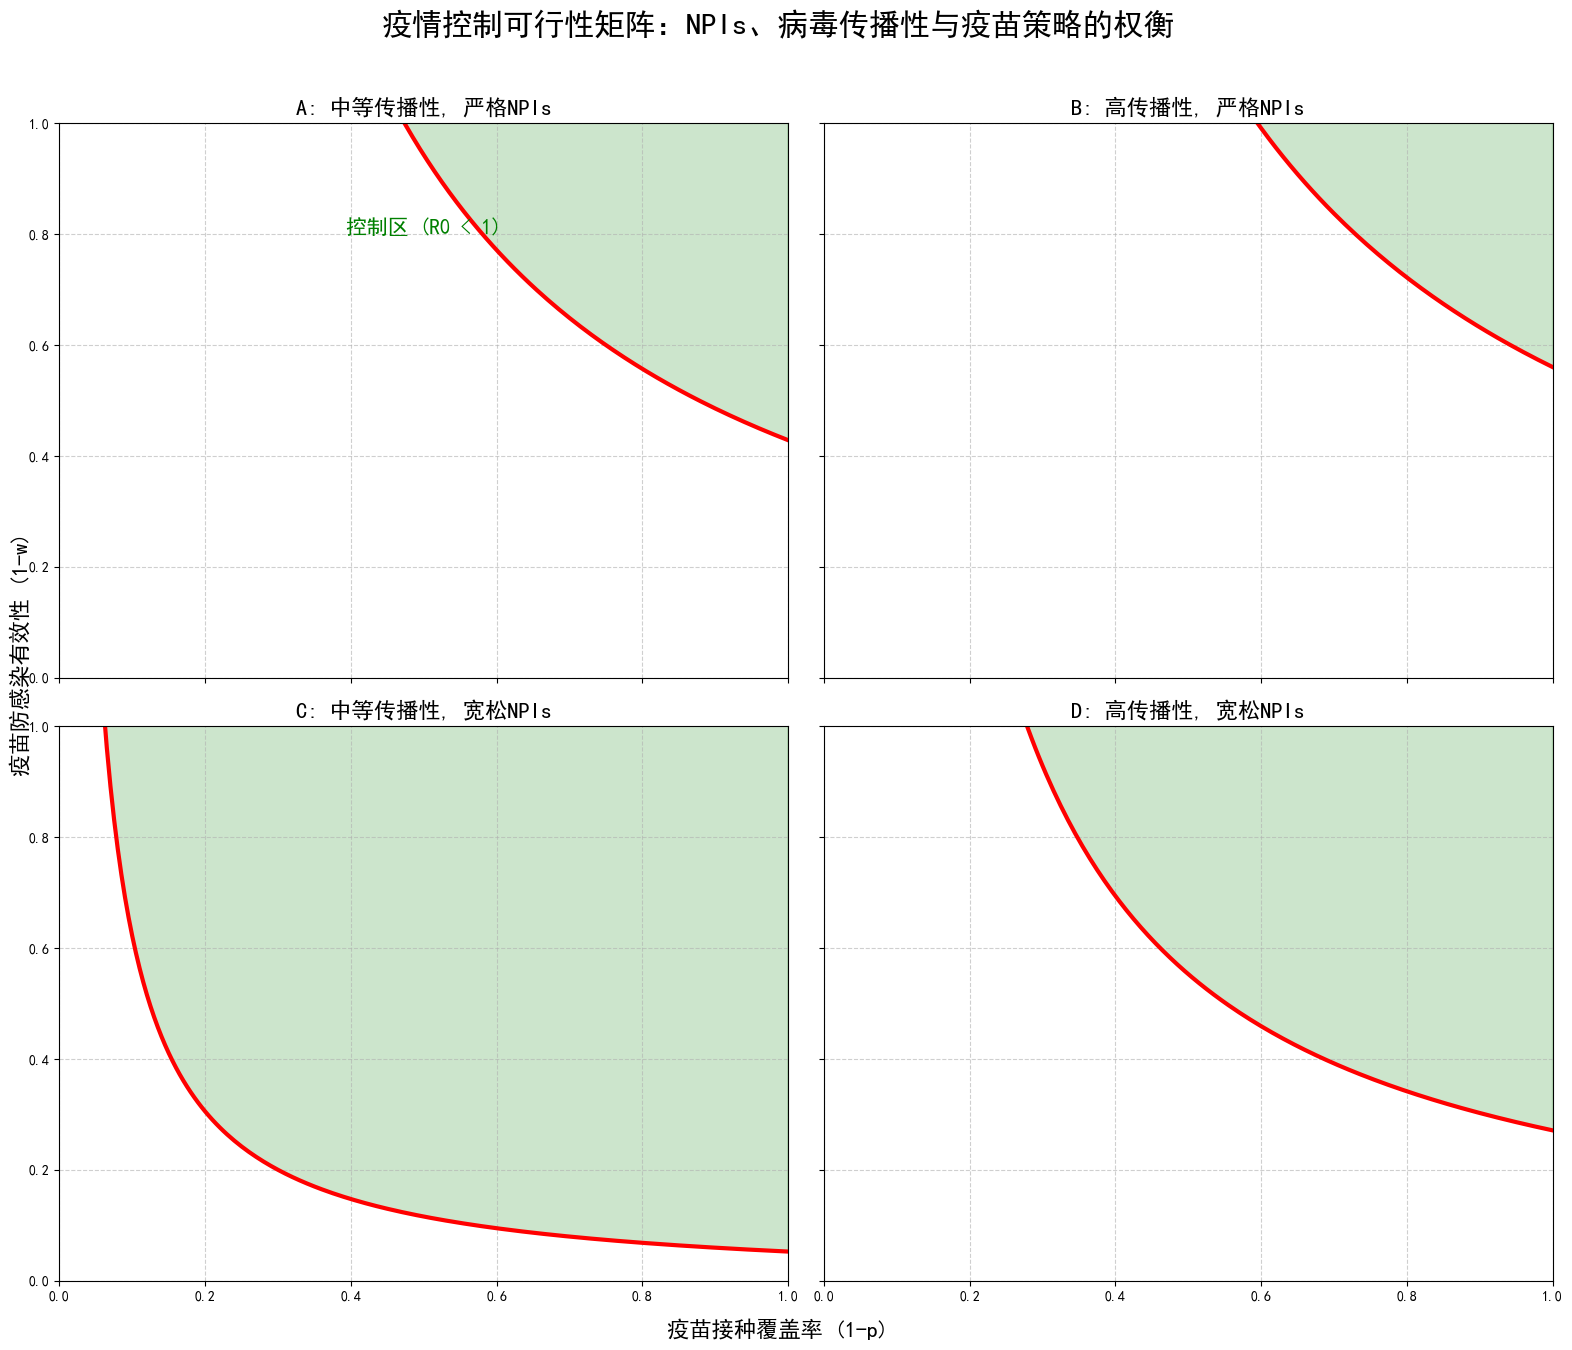

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和通用参数 ---

# 设置全局字体以支持中文显示和负号显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# --- ↓↓↓ 新增的核心函数 ↓↓↓ ---
def calculate_critical_w(p, beta_gamma_ratio, k, l, alpha):
    """
    为了使R0=1, 在给定其他参数的情况下, 计算所需的临界疫苗效力因子w_crit.
    该函数由 R0=1 的方程推导得出.
    """
    # 从 R0 = (beta/(k*gamma)) * Term_in_parens = 1 推导
    # Term_in_parens = k*gamma/beta
    term_in_parens_target = k / beta_gamma_ratio
    
    # Term_in_parens = p * term_unvaccinated_part + (1-p)*w*term_vaccinated_part
    term_unvaccinated_part = (l * alpha * (1 - k) + k)
    term_vaccinated_part = (l * (1 - k) + k)

    # (1-p)*w*term_vaccinated_part = term_in_parens_target - p * term_unvaccinated_part
    numerator = term_in_parens_target - p * term_unvaccinated_part
    denominator = (1 - p) * term_vaccinated_part

    # 避免除以零 (当p=1时)
    w_crit = np.full_like(p, np.nan)
    non_one_p = (p < 1.0) & (denominator != 0)
    
    # 计算w_crit, 只有在分母>0且分子>0时才有意义
    calculated_w = numerator[non_one_p] / denominator[non_one_p]
    w_crit[non_one_p] = calculated_w
    
    return w_crit
# --- ↑↑↑ 新增的核心函数结束 ↑↑↑ ---

# --- 核心分析: "疫情控制可行性矩阵" 实验 ---

# 1. 设定固定的模拟参数
gamma_val = 1.0/7.0
l_val = 0.5
alpha_val = 1.2

# 2. 定义2x2矩阵的四个场景
# (Transmissibility, NPIs)
scenarios = {
    'A': {'beta_gamma': 1.0, 'k': 0.4, 'title': 'A: 中等传播性, 严格NPIs'},
    'B': {'beta_gamma': 1.3, 'k': 0.4, 'title': 'B: 高传播性, 严格NPIs'},
    'C': {'beta_gamma': 1.0, 'k': 0.9, 'title': 'C: 中等传播性, 宽松NPIs'},
    'D': {'beta_gamma': 1.3, 'k': 0.9, 'title': 'D: 高传播性, 宽松NPIs'}
}

# 3. 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
axes = axes.flatten()

# 4. 循环每个场景并绘图
p_values = np.linspace(0, 1, 201) # 未接种比例
vaccination_coverage = 1 - p_values # 接种覆盖率

for i, key in enumerate(['A', 'B', 'C', 'D']):
    ax = axes[i]
    params = scenarios[key]
    
    # 计算临界疫苗效力 w
    w_crit = calculate_critical_w(p_values, params['beta_gamma'], params['k'], l_val, alpha_val)
    
    # 我们绘制的是疫苗的有效性 (1-w)，所以值越高越好
    vaccine_efficacy = 1 - w_crit
    
    # 绘制曲线
    ax.plot(vaccination_coverage, vaccine_efficacy, color='red', linewidth=3)
    
    # 填充 R0 < 1 的 "安全区"
    ax.fill_between(vaccination_coverage, vaccine_efficacy, 1, color='green', alpha=0.2)
    
    # 设置子图标题和网格
    ax.set_title(params['title'], fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # 在第一个图中添加安全区注释
    if i == 0:
        ax.text(0.5, 0.8, '控制区 (R0 < 1)', fontsize=15, color='green', ha='center')

# 5. 设置整个图的共享标签和总标题
fig.supxlabel('疫苗接种覆盖率 (1-p)', fontsize=16)
fig.supylabel('疫苗防感染有效性 (1-w)', fontsize=16)
fig.suptitle('疫情控制可行性矩阵：NPIs、病毒传播性与疫苗策略的权衡', fontsize=22, y=0.96)

plt.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig("疫情控制可行性矩阵.pdf", bbox_inches='tight')
plt.show()

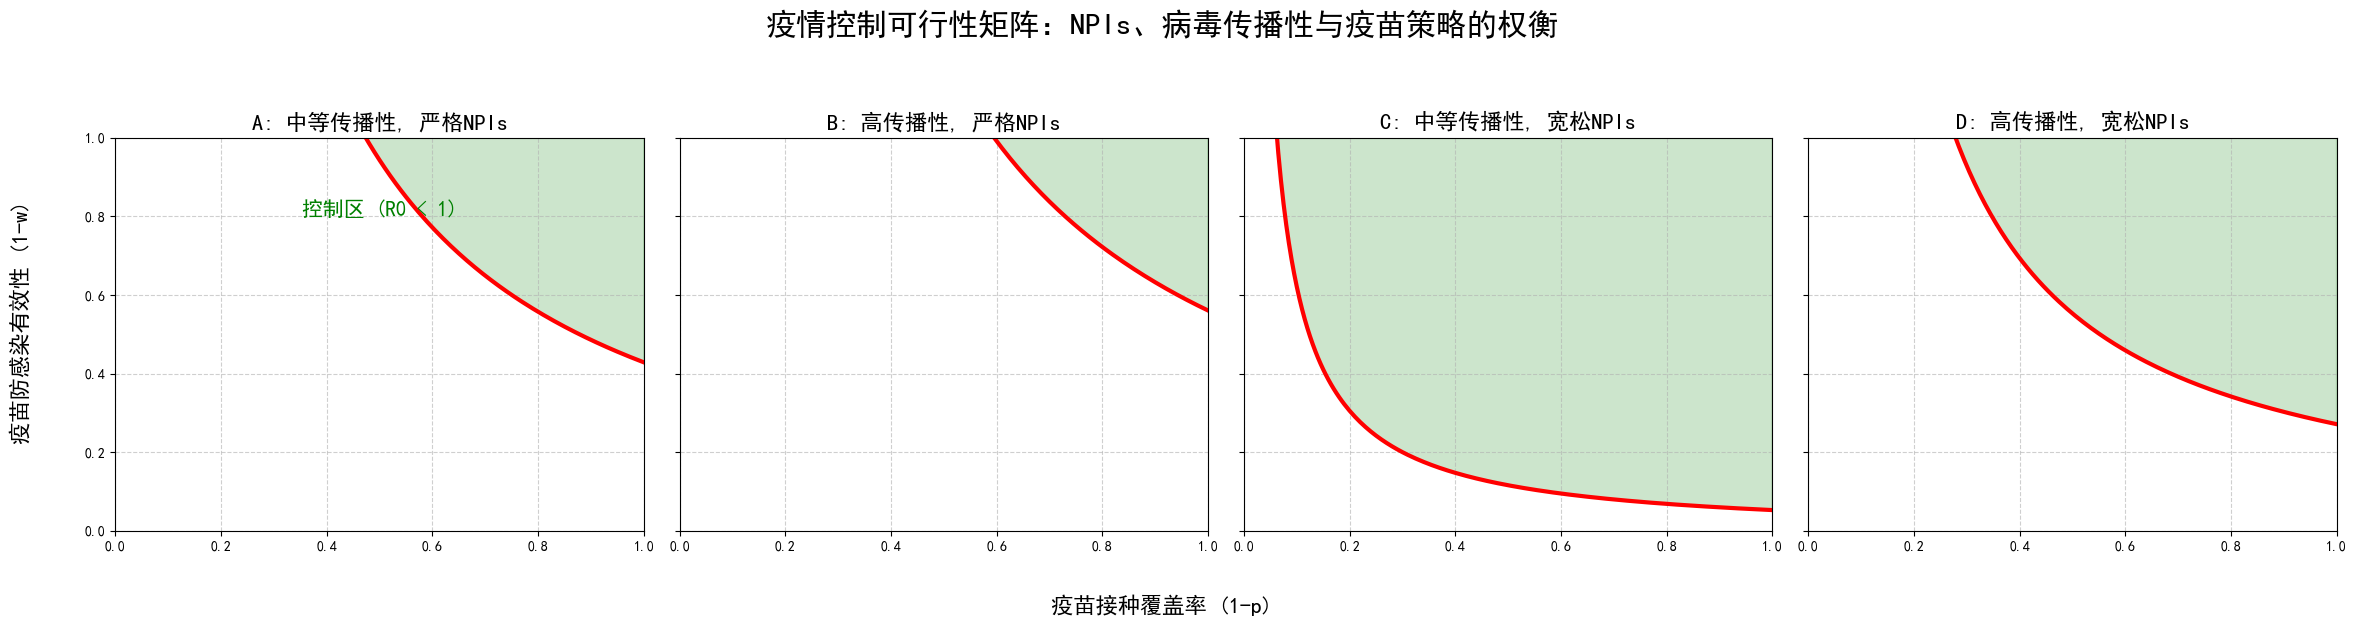

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和通用参数 ---

# 设置全局字体以支持中文显示和负号显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# --- 核心函数 ---
def calculate_critical_w(p, beta_gamma_ratio, k, l, alpha):
    """
    为了使R0=1, 在给定其他参数的情况下, 计算所需的临界疫苗效力因子w_crit.
    该函数由 R0=1 的方程推导得出.
    """
    term_in_parens_target = k / beta_gamma_ratio
    term_unvaccinated_part = (l * alpha * (1 - k) + k)
    term_vaccinated_part = (l * (1 - k) + k)

    numerator = term_in_parens_target - p * term_unvaccinated_part
    denominator = (1 - p) * term_vaccinated_part

    w_crit = np.full_like(p, np.nan)
    non_one_p = (p < 1.0) & (denominator != 0)
    
    calculated_w = numerator[non_one_p] / denominator[non_one_p]
    w_crit[non_one_p] = calculated_w
    
    return w_crit

# --- 核心分析: "疫情控制可行性矩阵" 实验 ---

# 1. 设定固定的模拟参数
gamma_val = 1.0/7.0
l_val = 0.5
alpha_val = 1.2

# 2. 定义四个场景
scenarios = {
    'A': {'beta_gamma': 1.0, 'k': 0.4, 'title': 'A: 中等传播性, 严格NPIs'},
    'B': {'beta_gamma': 1.3, 'k': 0.4, 'title': 'B: 高传播性, 严格NPIs'},
    'C': {'beta_gamma': 1.0, 'k': 0.9, 'title': 'C: 中等传播性, 宽松NPIs'},
    'D': {'beta_gamma': 1.3, 'k': 0.9, 'title': 'D: 高传播性, 宽松NPIs'}
}

# 3. 创建1x4的子图布局
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
axes = axes.flatten()

# 4. 循环每个场景并绘图
p_values = np.linspace(0, 1, 201) # 未接种比例
vaccination_coverage = 1 - p_values # 接种覆盖率

for i, key in enumerate(['A', 'B', 'C', 'D']):
    ax = axes[i]
    params = scenarios[key]
    
    w_crit = calculate_critical_w(p_values, params['beta_gamma'], params['k'], l_val, alpha_val)
    vaccine_efficacy = 1 - w_crit
    
    ax.plot(vaccination_coverage, vaccine_efficacy, color='red', linewidth=3)
    ax.fill_between(vaccination_coverage, vaccine_efficacy, 1, color='green', alpha=0.2)
    
    # 每个子图的小标题
    ax.set_title(params['title'], fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # 在第一个图中添加安全区注释
    if i == 0:
        ax.text(0.5, 0.8, '控制区 (R0 < 1)', fontsize=15, color='green', ha='center')

# 5. 设置整个图的共享标签和总标题
fig.supxlabel('疫苗接种覆盖率 (1-p)', fontsize=16)
fig.supylabel('疫苗防感染有效性 (1-w)', fontsize=16)
fig.suptitle('疫情控制可行性矩阵：NPIs、病毒传播性与疫苗策略的权衡', fontsize=22, y=1.02)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])

# --- ↓↓↓ 这里是唯一的修改 ↓↓↓ ---
# fig.savefig("疫情控制可行性矩阵_横向排列.pdf", bbox_inches='tight') # 此行已被移除
# --- ↑↑↑ 修改结束 ↑↑↑ ---

plt.show()

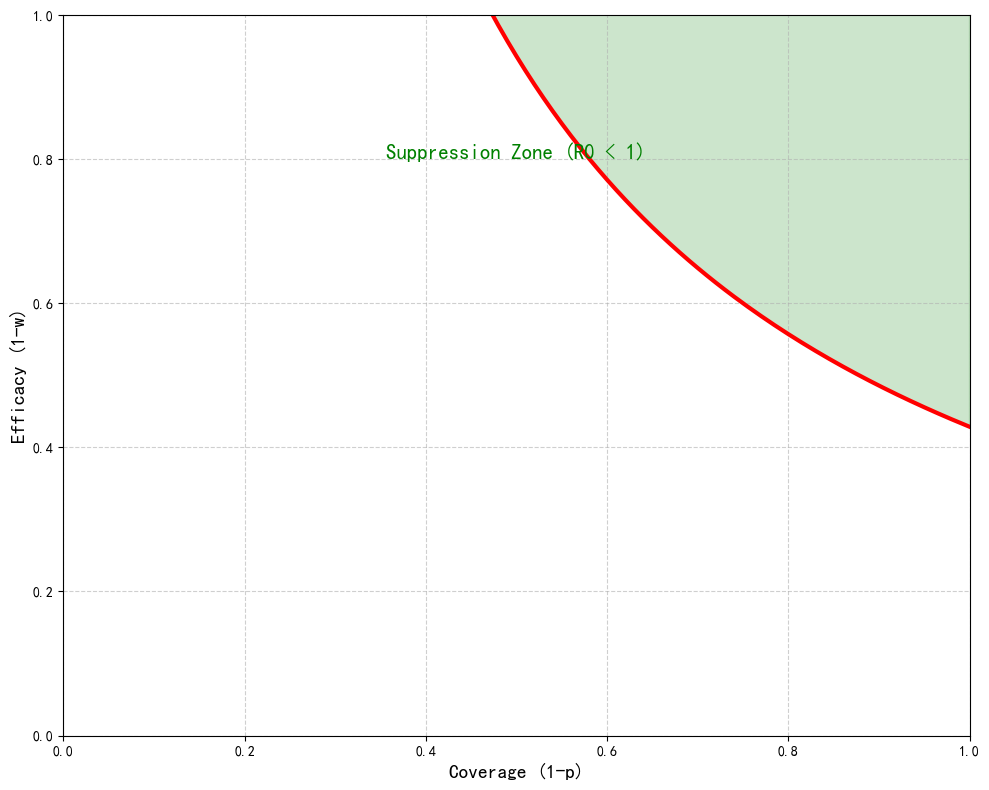

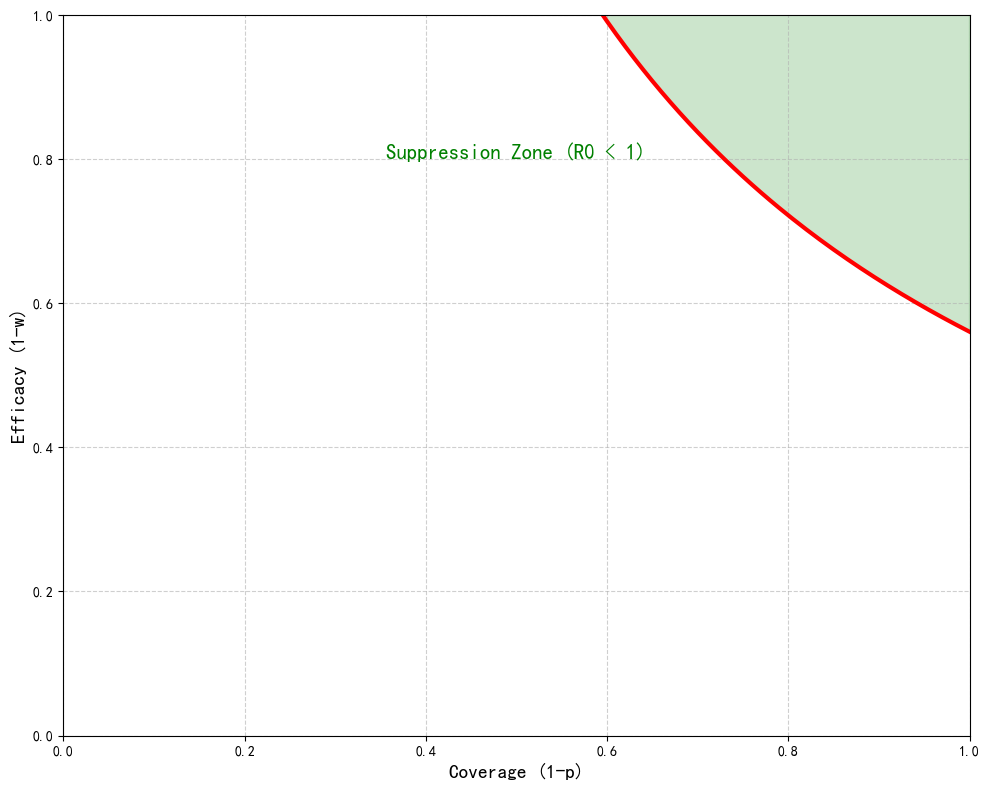

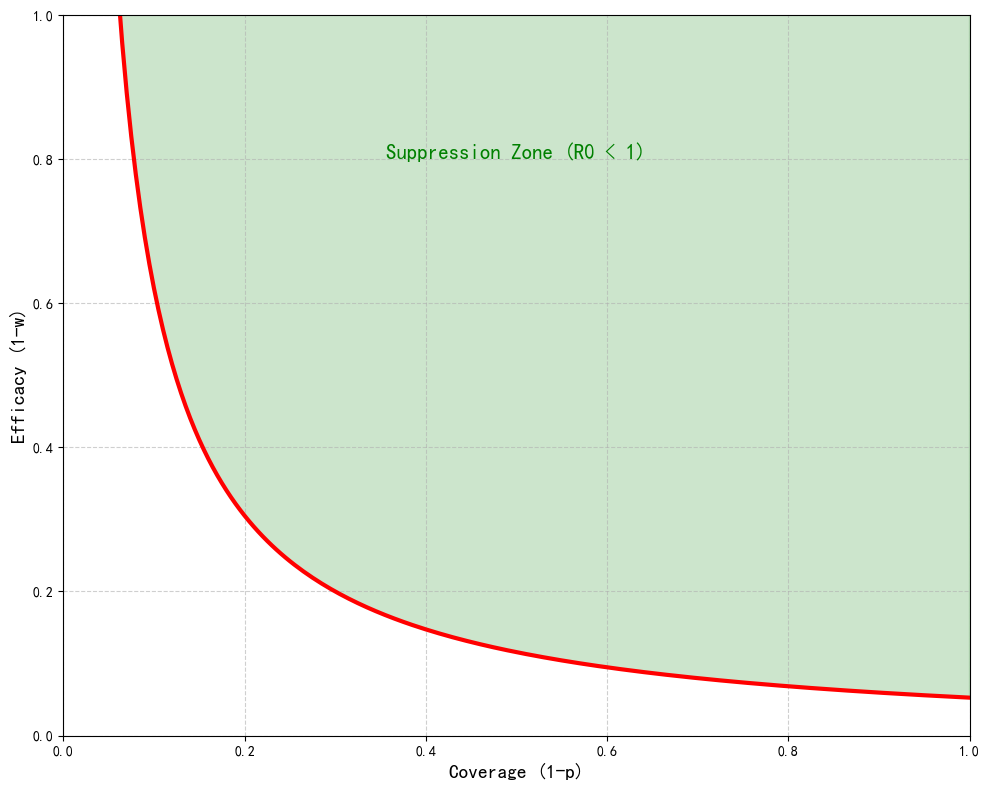

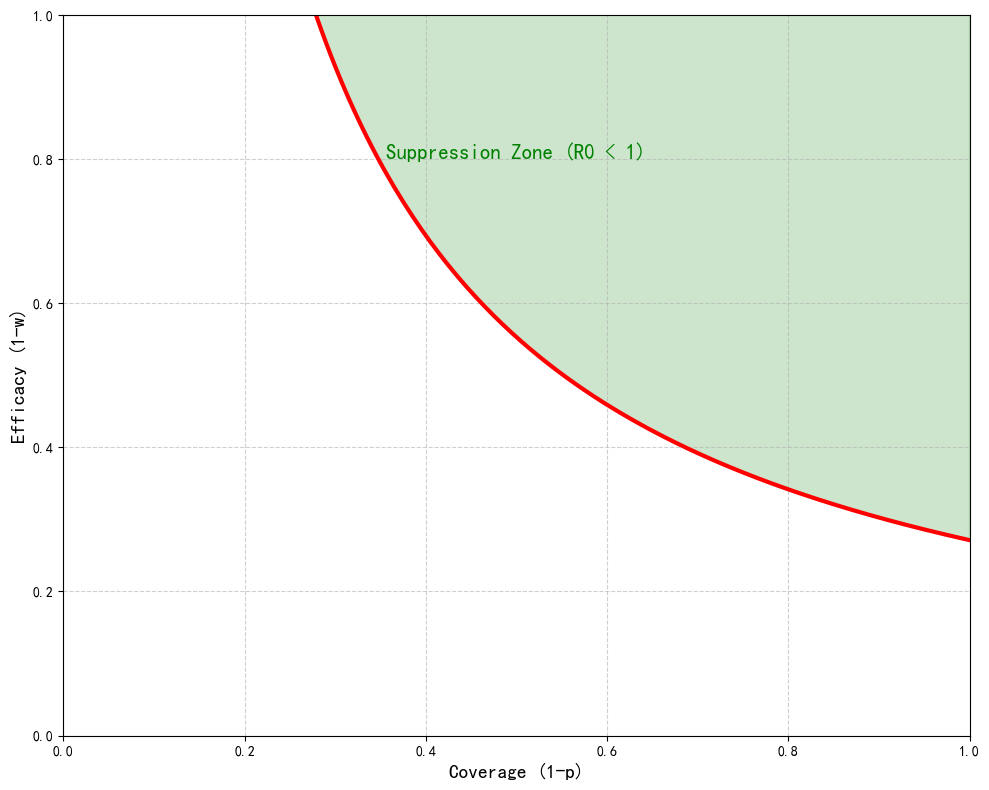

正在生成并保存四张独立的图...
图像已保存: A_中等传播性_严格NPIs.pdf
图像已保存: B_高传播性_严格NPIs.pdf
图像已保存: C_中等传播性_宽松NPIs.pdf
图像已保存: D_高传播性_宽松NPIs.pdf


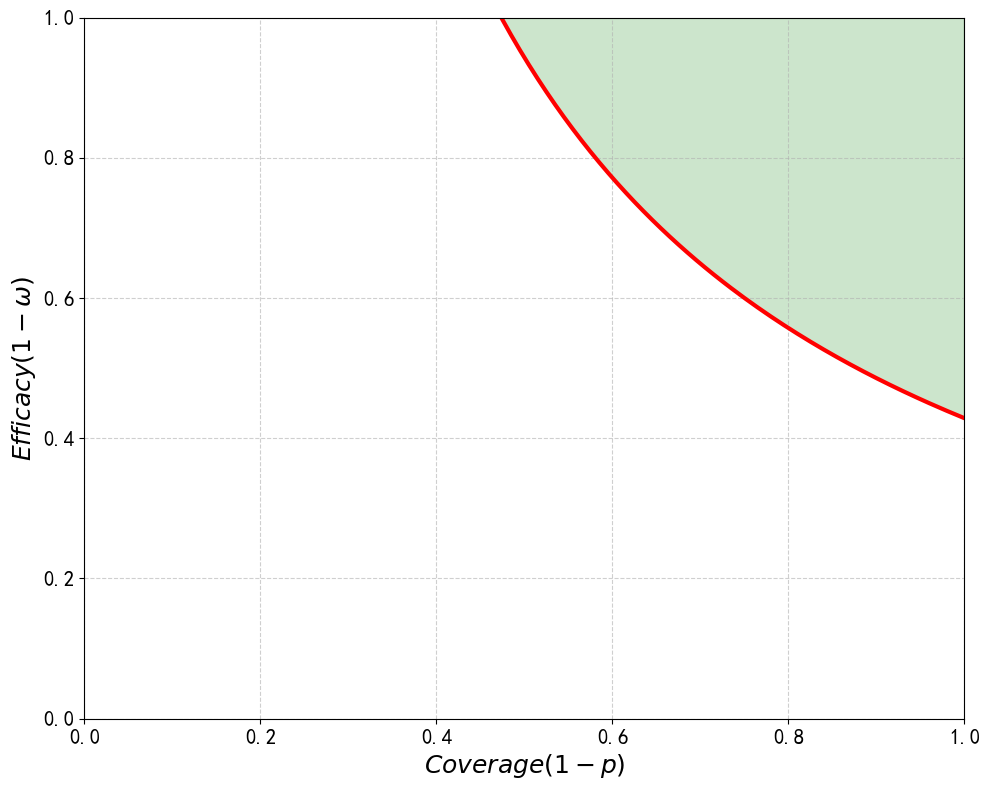

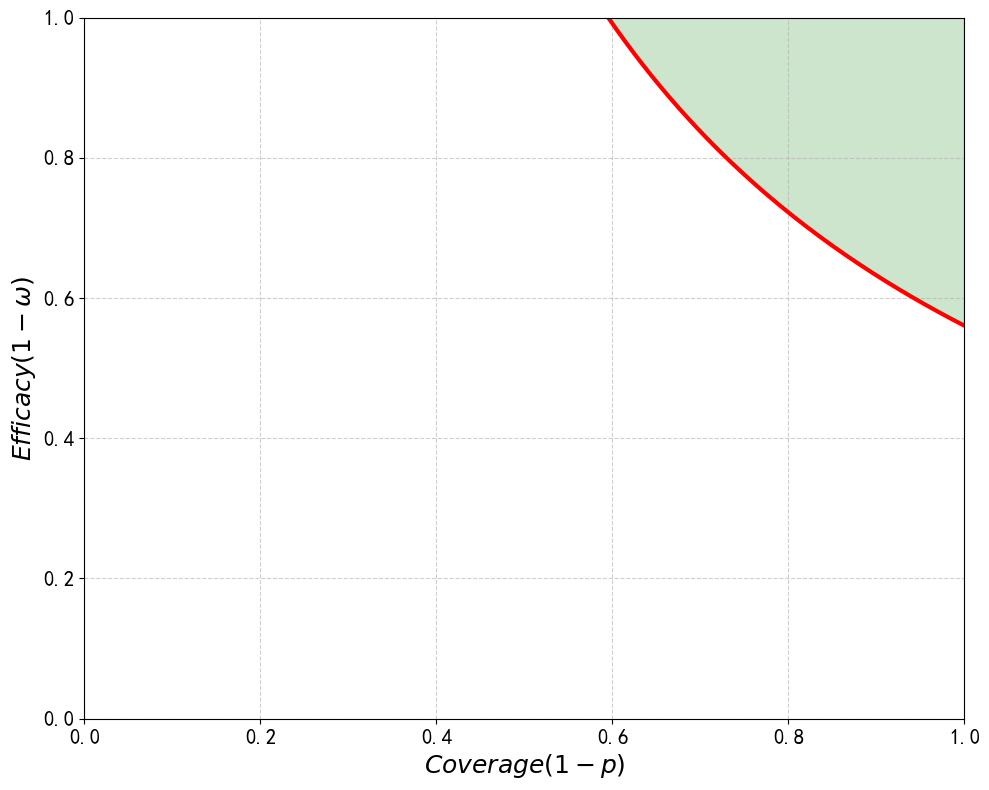

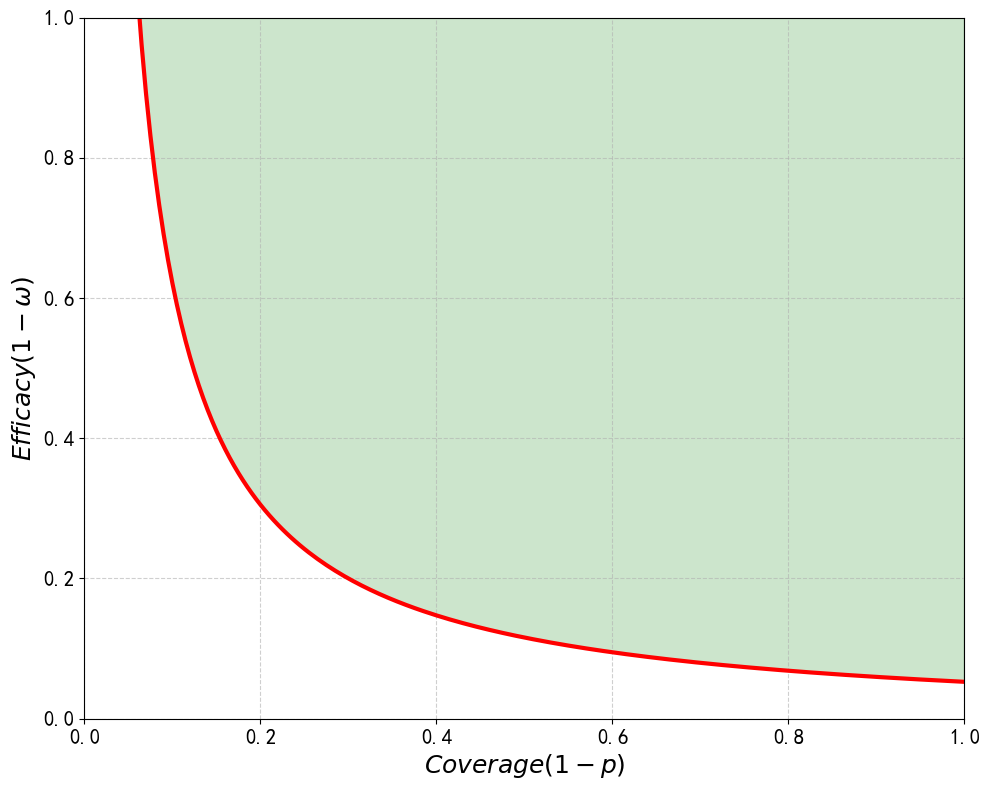

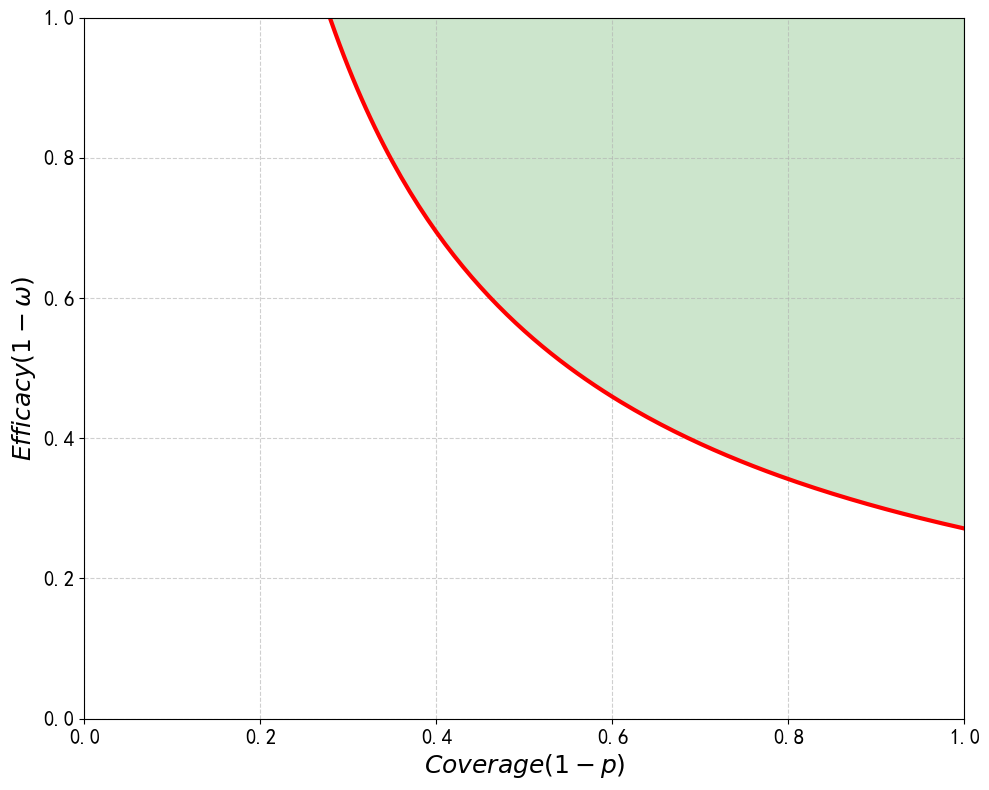


所有图像已生成并保存完毕。


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 准备工作: 定义函数和通用参数 ---

# 设置全局字体以支持中文显示和负号显示
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# --- 核心函数 ---
def calculate_critical_w(p, beta_gamma_ratio, k, l, alpha):
    """
    为了使R0=1, 在给定其他参数的情况下, 计算所需的临界疫苗效力因子w_crit.
    该函数由 R0=1 的方程推导得出.
    """
    term_in_parens_target = k / beta_gamma_ratio
    term_unvaccinated_part = (l * alpha * (1 - k) + k)
    term_vaccinated_part = (l * (1 - k) + k)

    numerator = term_in_parens_target - p * term_unvaccinated_part
    denominator = (1 - p) * term_vaccinated_part

    w_crit = np.full_like(p, np.nan)
    non_one_p = (p < 1.0) & (denominator != 0)
    
    calculated_w = numerator[non_one_p] / denominator[non_one_p]
    w_crit[non_one_p] = calculated_w
    
    return w_crit

# --- 核心分析: "疫情控制可行性矩阵" 实验 ---

# 1. 设定固定的模拟参数
gamma_val = 1.0/7.0
l_val = 0.5
alpha_val = 1.2

# 2. 定义四个场景
scenarios = {
    'A': {'beta_gamma': 1.0, 'k': 0.4, 'title': 'A: 中等传播性, 严格NPIs'},
    'B': {'beta_gamma': 1.3, 'k': 0.4, 'title': 'B: 高传播性, 严格NPIs'},
    'C': {'beta_gamma': 1.0, 'k': 0.9, 'title': 'C: 中等传播性, 宽松NPIs'},
    'D': {'beta_gamma': 1.3, 'k': 0.9, 'title': 'D: 高传播性, 宽松NPIs'}
}


# 3. 循环每个场景并为每个场景创建一张独立的图
print("正在生成并保存四张独立的图...")
for key in ['A', 'B', 'C', 'D']:
    
    # 3.1. 在循环内部创建独立的图窗和坐标轴
    fig, ax = plt.subplots(figsize=(10, 8))
    
    params = scenarios[key]
    
    # 3.2. 数据计算
    p_values = np.linspace(0, 1, 201) # 未接种比例
    vaccination_coverage = 1 - p_values # 接种覆盖率
    w_crit = calculate_critical_w(p_values, params['beta_gamma'], params['k'], l_val, alpha_val)
    vaccine_efficacy = 1 - w_crit
    
    # 3.3. 绘图
    ax.plot(vaccination_coverage, vaccine_efficacy, color='red', linewidth=3)
    ax.fill_between(vaccination_coverage, vaccine_efficacy, 1, color='green', alpha=0.2)
    
    # 3.4. 为每一张独立的图添加完整的注释
#     ax.set_title(params['title'], fontsize=18)
    ax.set_xlabel(r'$Coverage (1-p)$', fontsize=18)
    ax.set_ylabel(r'$Efficacy (1-\omega)$', fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', labelsize=15)
#     ax.text(0.5, 0.8, 'Suppression Zone (R0 < 1)', fontsize=15, color='green', ha='center')

    # 调整当前这张图的布局
    plt.tight_layout()

#     --- ↓↓↓ 这里是新添加的PDF保存代码 ↓↓↓ ---
#     1. 根据场景标题创建一个安全的文件名
    safe_title = params['title'].replace(':', '').replace(',', '').replace(' ', '_')
    filename = f"{safe_title}.pdf"

    # 2. 保存当前图窗为PDF文件
    fig.savefig(filename, bbox_inches='tight')
    print(f"图像已保存: {filename}")
    # --- ↑↑↑ PDF保存代码结束 ↑↑↑ ---


# 4. 在所有循环结束后，一次性显示所有创建的图窗
plt.show()
print("\n所有图像已生成并保存完毕。")